In [1]:
import tensorflow as tf
tf.__version__
tf.config.experimental.enable_op_determinism()
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
  tf.config.experimental.set_memory_growth(gpu, True)

2023-11-21 17:25:52.216944: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-21 17:25:52.717041: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2023-11-21 17:25:53.264234: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-11-21 17:25:53.287501: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA n

In [2]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
import random
from tensorflow.keras import regularizers

In [3]:
def plot_columns(df):
    colors = plt.cm.tab20(range(df.shape[1]))  

    for i, column in enumerate(df.columns):
        color = colors[i % 24]

        plt.figure()
        plt.plot(df.index, df[column], color=color)
        plt.xlabel('Tempo')
        plt.ylabel('Valor')
        plt.title(column)

    plt.show()

In [4]:
def plot_correlation_matrix(df):
    correlation_matrix = df.corr()
    plt.figure(figsize=(10, 8))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
    plt.title("Correlation Matrix Heatmap")
    plt.show()

In [5]:
tf.keras.backend.clear_session()

In [6]:
import shap
shap.initjs()

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


In [7]:
subject = 'São Paulo - Consumo de Cimento (t)'
start_index = 0
split_index = 179
window_size = 0
train_split = split_index + 1 - 12

In [8]:
data = pd.read_csv('2003_mo_model_input_SP.csv')
pd.set_option('display.max_columns', None)
data

Unnamed: 0  São Paulo- custo m2 (R$)  São Paulo - IDH Longevidade  \
0       2003-1              12606.426400                     0.835043   
1       2003-2              12718.304862                     0.835425   
2       2003-3              12824.573380                     0.835806   
3       2003-4              12924.495880                     0.836188   
4       2003-5              13031.542087                     0.836570   
..         ...                       ...                          ...   
244     2023-5              39560.290067                          NaN   
245     2023-6              39516.207562                          NaN   
246     2023-7              39457.198332                          NaN   
247     2023-8              39382.246174                          NaN   
248     2023-9              39286.151420                          NaN   

     São Paulo - IDH Renda  São Paulo - Consumo de Cimento (t)  \
0                 0.825444                             782.111   
1                 0.825117                             789.891   
2                 0.824790                             774.309   
3                 0.824463                             782.071   
4                 0.824137                             841.400   
..                     ...                                 ...   
244                    NaN                                 NaN   
245                    NaN                                 NaN   
246                    NaN                                 NaN   
247                    NaN                                 NaN   
248                    NaN                                 NaN   

     Precipitação (mm/day)  Pressão Atmosférica (mB)  \
0                 1.249379                836.486933   
1                 1.114976                836.981236   
2                 0.946194                837.344257   
3                 0.857395                837.859987   
4                 0.688185                838.094744   
..                     ...                       ...   
244                    NaN                       NaN   
245                    NaN                       NaN   
246                    NaN                       NaN   
247                    NaN                       NaN   
248                    NaN                       NaN   

     Radiação Global - Dia (Kj/m²)  Temperatura do Ar - Bulbo Seco (°C)  \
0                      1254.225718                            13.470493   
1                      1268.256958                            13.555238   
2                      1270.950707                            13.460122   
3                      1261.707476                            13.181964   
4                      1264.729439                            12.670356   
..                             ...                                  ...   
244                            NaN                                  NaN   
245                            NaN                                  NaN   
246                            NaN                                  NaN   
247                            NaN                                  NaN   
248                            NaN                                  NaN   

     Temperatura de Ponto de Orvalho (°C)  Humidade Relativa do Ar (%)  \
0                               11.219632                    87.918957   
1                               10.140963                    82.539126   
2                                9.537375                    80.042714   
3                                8.663709                    77.171627   
4                                7.872689                    75.721222   
..                                    ...                          ...   
244                                   NaN                          NaN   
245                                   NaN                          NaN   
246                                   NaN                          NaN   
247                 

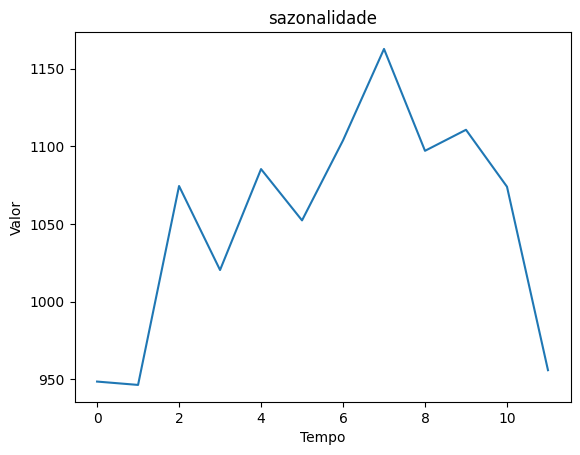

sazonalidade
sazonalidade              
0               948.563205
1               946.405094
2              1074.415372
3              1020.345809
4              1085.308859
5              1052.289874
6              1103.779201
7              1162.634306
8              1097.065581
9              1110.594849
10             1073.958197
11              955.883036

In [9]:
def calculate_monthly_means(consume_of_cement, subject):
    df = pd.DataFrame({subject: consume_of_cement[:train_split]})
    df['sazonalidade'] = df.index % 12
    monthly_means = df.groupby('sazonalidade')[subject].mean()
    result_df = pd.DataFrame({'sazonalidade': monthly_means})

    return result_df

media_df = calculate_monthly_means(data[subject], subject)
plot_columns(media_df)
media_df

In [10]:
def fill_original_df_with_monthly_means(df_og, media_df):
    monthly_means = media_df['sazonalidade'].tolist()
    df_og['sazonalidade'] = [monthly_means[i % 12] for i in range(len(df_og))]
    return df_og

data = fill_original_df_with_monthly_means(data, media_df)
data = data[[col for col in data.columns if col != subject] + [subject]] #Seta consumo (target) para a coluna final
data

Unnamed: 0  São Paulo- custo m2 (R$)  São Paulo - IDH Longevidade  \
0       2003-1              12606.426400                     0.835043   
1       2003-2              12718.304862                     0.835425   
2       2003-3              12824.573380                     0.835806   
3       2003-4              12924.495880                     0.836188   
4       2003-5              13031.542087                     0.836570   
..         ...                       ...                          ...   
244     2023-5              39560.290067                          NaN   
245     2023-6              39516.207562                          NaN   
246     2023-7              39457.198332                          NaN   
247     2023-8              39382.246174                          NaN   
248     2023-9              39286.151420                          NaN   

     São Paulo - IDH Renda  Precipitação (mm/day)  Pressão Atmosférica (mB)  \
0                 0.825444               1.249379                836.486933   
1                 0.825117               1.114976                836.981236   
2                 0.824790               0.946194                837.344257   
3                 0.824463               0.857395                837.859987   
4                 0.824137               0.688185                838.094744   
..                     ...                    ...                       ...   
244                    NaN                    NaN                       NaN   
245                    NaN                    NaN                       NaN   
246                    NaN                    NaN                       NaN   
247                    NaN                    NaN                       NaN   
248                    NaN                    NaN                       NaN   

     Radiação Global - Dia (Kj/m²)  Temperatura do Ar - Bulbo Seco (°C)  \
0                      1254.225718                            13.470493   
1                      1268.256958                            13.555238   
2                      1270.950707                            13.460122   
3                      1261.707476                            13.181964   
4                      1264.729439                            12.670356   
..                             ...                                  ...   
244                            NaN                                  NaN   
245                            NaN                                  NaN   
246                            NaN                                  NaN   
247                            NaN                                  NaN   
248                            NaN                                  NaN   

     Temperatura de Ponto de Orvalho (°C)  Humidade Relativa do Ar (%)  \
0                               11.219632                    87.918957   
1                               10.140963                    82.539126   
2                                9.537375                    80.042714   
3                                8.663709                    77.171627   
4                                7.872689                    75.721222   
..                                    ...                          ...   
244                                   NaN                          NaN   
245                                   NaN                          NaN   
246                                   NaN                          NaN   
247                                   NaN                          NaN   
248                                   NaN                          NaN   

     Velocidade do Vento (m/s)  São Paulo - Produção de Cimento (t)  \
0                     1.587388                           437.972720   
1                     1.957841                           434.363720   
2                     2.068918                           433.350868   
3                     2.177406                           431.825332   
4                     2.092594   

In [11]:
# Shift para prever futuro e não presente
target_data = data[subject].shift(-24)
target_data

0      656.269
1      745.154
2      788.618
3      790.169
4      791.663
        ...   
244        NaN
245        NaN
246        NaN
247        NaN
248        NaN
Name: São Paulo - Consumo de Cimento (t), Length: 249, dtype: float64

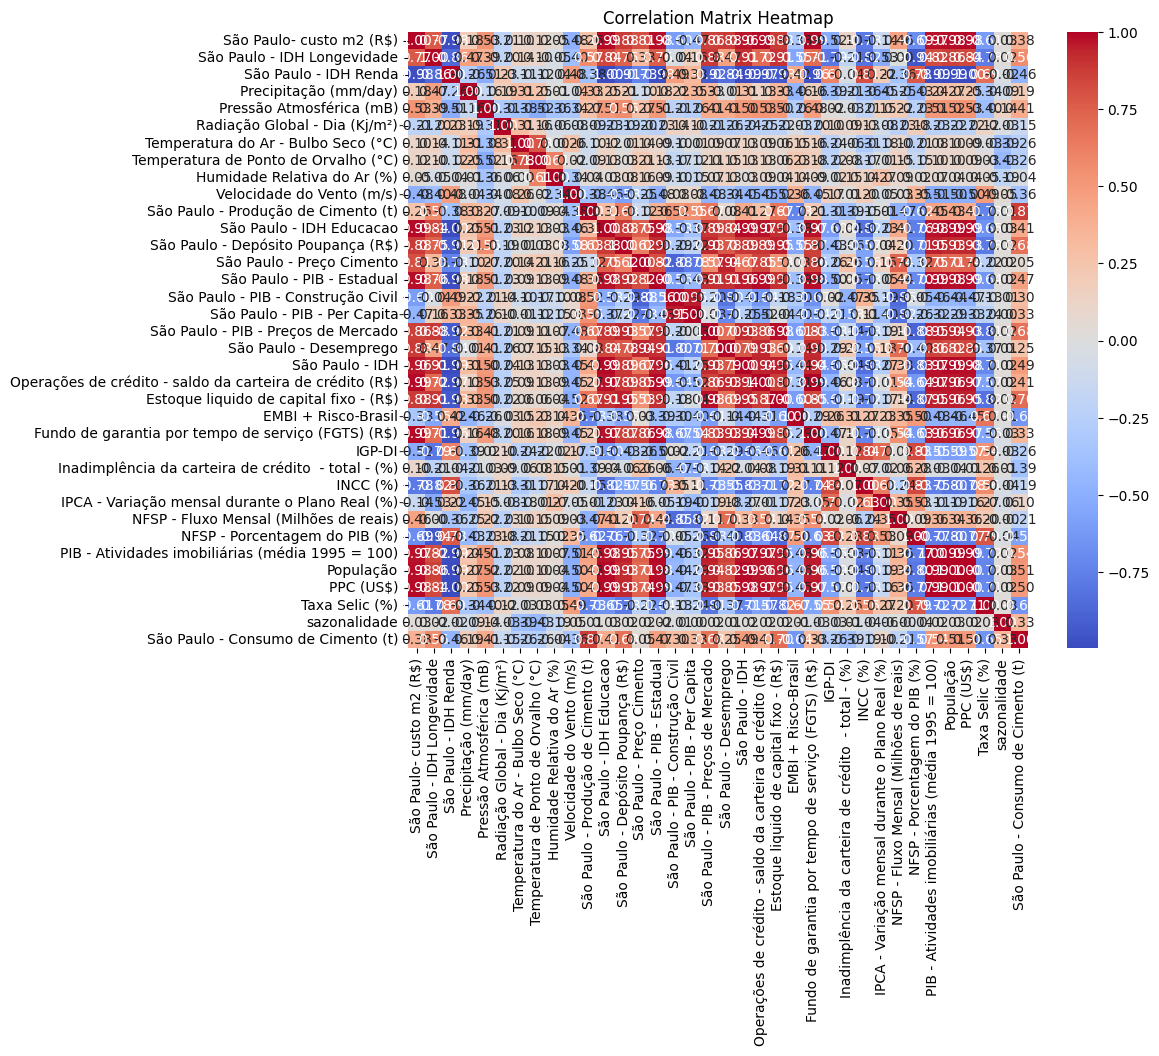

In [12]:
plot_data = data.iloc[:split_index + 1,1:]
plot_correlation_matrix(plot_data)

In [13]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

safe_data = data.iloc[:split_index + 1,1:-1]

def calculate_vif(dataframe):
    vif_data = pd.DataFrame()
    vif_data["Feature"] = dataframe.columns
    vif_data["VIF"] = [variance_inflation_factor(dataframe.values, i) for i in range(dataframe.shape[1])]
    return vif_data

def remove_high_vif_columns(dataframe, threshold=1000):
    i=0
    while True:
        vif_result = calculate_vif(dataframe)
        high_vif_column = vif_result.loc[vif_result["VIF"].idxmax()]["Feature"]
        
        if vif_result["VIF"].max() <= threshold:
            print(f"Num columns removed: {i}")
            return dataframe
        i += 1
        dataframe = dataframe.drop(high_vif_column, axis=1)

In [14]:
safe_data = data.iloc[:split_index + 1,1:-1]
vif_info = calculate_vif(safe_data)
vif_info

Feature           VIF
0                            São Paulo- custo m2 (R$)  1.116376e+05
1                         São Paulo - IDH Longevidade  3.574864e+04
2                               São Paulo - IDH Renda  1.812908e+08
3                               Precipitação (mm/day)  5.082396e+00
4                            Pressão Atmosférica (mB)  1.651533e+01
5                       Radiação Global - Dia (Kj/m²)  4.174709e+00
6                 Temperatura do Ar - Bulbo Seco (°C)  6.685410e+02
7                Temperatura de Ponto de Orvalho (°C)  1.090285e+03
8                         Humidade Relativa do Ar (%)  5.140547e+02
9                           Velocidade do Vento (m/s)  9.837355e+00
10                São Paulo - Produção de Cimento (t)  4.434927e+03
11                           São Paulo - IDH Educacao  8.925698e+05
12                 São Paulo - Depósito Poupança (R$)  1.223327e+03
13                          São Paulo - Preço Cimento  2.863542e+03
14                         São Paulo - PIB - Estadual  1.282949e+06
15                 São Paulo - PIB - Construção Civil  3.131234e+04
16                       São Paulo - PIB - Per Capita  9.104088e+04
17                São Paulo - PIB - Preços de Mercado  8.763367e+09
18                             São Paulo - Desemprego  3.716719e+03
19                                    São Paulo - IDH  5.794616e+04
20  Operações de crédito - saldo da carteira de cr...  5.008862e+04
21             Estoque liquido de capital fixo - (R$)  4.213415e+05
22                                EMBI + Risco-Brasil  1.061792e+02
23  Fundo de garantia por tempo de serviço (FGTS) ...  4.346202e+02
24                                             IGP-DI  5.730039e+01
25  Inadimplência da carteira de crédito  - total ...  1.292451e+02
26                                           INCC (%)  1.318956e+02
27    IPCA - Variação mensal durante o Plano Real (%)  3.224082e+02
28             NFSP - Fluxo Mensal (Milhões de reais)  7.457785e+01
29                      NFSP - Porcentagem do PIB (%)  1.575564e+03
30   PIB - Atividades imobiliárias (média 1995 = 100)  7.476209e+03
31                                          População  1.429583e+05
32                                          PPC (US$)  6.431120e+04
33                                     Taxa Selic (%)  8.650658e+00
34                                       sazonalidade  2.461081e+00

In [15]:
data = remove_high_vif_columns(safe_data, 100000000)
data

Num columns removed: 4


São Paulo- custo m2 (R$)  São Paulo - IDH Longevidade  \
0                12606.426400                     0.835043   
1                12718.304862                     0.835425   
2                12824.573380                     0.835806   
3                12924.495880                     0.836188   
4                13031.542087                     0.836570   
..                        ...                          ...   
175              27531.564291                     0.853759   
176              27630.818262                     0.853505   
177              27729.356714                     0.853252   
178              27826.924064                     0.852998   
179              27921.300957                     0.852745   

     São Paulo - IDH Renda  Precipitação (mm/day)  Pressão Atmosférica (mB)  \
0                 0.825444               1.249379                836.486933   
1                 0.825117               1.114976                836.981236   
2                 0.824790               0.946194                837.344257   
3                 0.824463               0.857395                837.859987   
4                 0.824137               0.688185                838.094744   
..                     ...                    ...                       ...   
175               0.785144               1.649188                837.635678   
176               0.785130               1.868389                836.999039   
177               0.785117               1.791335                836.162555   
178               0.785103               1.640566                835.659694   
179               0.785090               1.560306                835.546717   

     Radiação Global - Dia (Kj/m²)  Temperatura do Ar - Bulbo Seco (°C)  \
0                      1254.225718                            13.470493   
1                      1268.256958                            13.555238   
2                      1270.950707                            13.460122   
3                      1261.707476                            13.181964   
4                      1264.729439                            12.670356   
..                             ...                                  ...   
175                    1259.264356                            14.381597   
176                    1310.279490                            15.154465   
177                    1273.447578                            15.737382   
178                    1266.491442                            16.049727   
179                    1287.672336                            16.598028   

     Temperatura de Ponto de Orvalho (°C)  Humidade Relativa do Ar (%)  \
0                               11.219632                    87.918957   
1                               10.140963                    82.539126   
2                                9.537375                    80.042714   
3                                8.663709                    77.171627   
4                                7.872689                    75.721222   
..                                    ...                          ...   
175                              9.444378                    75.646877   
176                             10.416956                    76.752779   
177                             11.832353                    80.433404   
178                             12.619759                    82.715561   
179                             13.500429                    84.315779   

     Velocidade do Vento (m/s)  São Paulo - Produção de Cimento (t)  \
0                     1.587388                           437.972720   
1                     1.957841                           434.363720   
2                     2.068918                           433.350868   
3                     2.177406                           431.825332   
4                     2.092594                           433.287298   
..                         ...                                  ...   
175                   1.

In [16]:
input_data = data.iloc[:split_index + 1,1:]
mean = np.mean(input_data, axis=0)
stddev =  np.std(input_data, axis=0)
input_data = ((input_data - mean) /stddev)
# scaler=MinMaxScaler()
# scaled_data = scaler.fit_transform(input_data)
# input_data = pd.DataFrame(scaled_data, columns=input_data.columns)
input_data

São Paulo - IDH Longevidade  São Paulo - IDH Renda  \
0                      -2.915633               1.941338   
1                      -2.843323               1.913989   
2                      -2.771012               1.886640   
3                      -2.698701               1.859291   
4                      -2.626390               1.831942   
..                           ...                    ...   
175                     0.629265              -1.430990   
176                     0.581244              -1.432108   
177                     0.533224              -1.433226   
178                     0.485203              -1.434343   
179                     0.437183              -1.435461   

     Precipitação (mm/day)  Pressão Atmosférica (mB)  \
0                -0.290685                  0.168043   
1                -0.747488                  0.528527   
2                -1.321140                  0.793270   
3                -1.622949                  1.169382   
4                -2.198056                  1.340585   
..                     ...                       ...   
175               1.068176                  1.005798   
176               1.813190                  0.541510   
177               1.551304                 -0.068519   
178               1.038873                 -0.435245   
179               0.766088                 -0.517637   

     Radiação Global - Dia (Kj/m²)  Temperatura do Ar - Bulbo Seco (°C)  \
0                         0.523863                            -1.331288   
1                         0.633468                            -1.264617   
2                         0.654510                            -1.339447   
3                         0.582307                            -1.558281   
4                         0.605913                            -1.960777   
..                             ...                                  ...   
175                       0.563222                            -0.614498   
176                       0.961726                            -0.006461   
177                       0.674014                             0.452135   
178                       0.619677                             0.697865   
179                       0.785131                             1.129229   

     Temperatura de Ponto de Orvalho (°C)  Humidade Relativa do Ar (%)  \
0                               -0.216635                     1.280435   
1                               -0.852136                     0.252570   
2                               -1.207742                    -0.224391   
3                               -1.722465                    -0.772938   
4                               -2.188497                    -1.050051   
..                                    ...                          ...   
175                             -1.262532                    -1.064255   
176                             -0.689534                    -0.852963   
177                              0.144352                    -0.149747   
178                              0.608255                     0.286280   
179                              1.127104                     0.592016   

     Velocidade do Vento (m/s)  São Paulo - Produção de Cimento (t)  \
0                    -0.108482                            -1.519153   
1                     0.508318                            -1.549917   
2                     0.693259                            -1.558550   
3                     0.873892                            -1.571554   
4                     0.732680                            -1.559092   
..                         ...                                  ...   
175                  -0.876820                            -1.246570   
176                  -0.870361                            -1.274708   
177                  -0.901120                            -1.273203   
178                  -0.899670                            -1.288018   
179                  -0.944527                      

In [17]:
# input para treinamento
train_input = input_data.iloc[start_index:train_split]
train_input

São Paulo - IDH Longevidade  São Paulo - IDH Renda  \
0                      -2.915633               1.941338   
1                      -2.843323               1.913989   
2                      -2.771012               1.886640   
3                      -2.698701               1.859291   
4                      -2.626390               1.831942   
..                           ...                    ...   
163                     1.159197              -1.432572   
164                     1.120439              -1.430691   
165                     1.081681              -1.428810   
166                     1.042924              -1.426929   
167                     1.004166              -1.425048   

     Precipitação (mm/day)  Pressão Atmosférica (mB)  \
0                -0.290685                  0.168043   
1                -0.747488                  0.528527   
2                -1.321140                  0.793270   
3                -1.622949                  1.169382   
4                -2.198056                  1.340585   
..                     ...                       ...   
163               0.308626                  0.586075   
164               0.413345                  0.259655   
165               0.123727                  0.008100   
166              -0.571047                 -0.052271   
167              -1.032718                  0.015262   

     Radiação Global - Dia (Kj/m²)  Temperatura do Ar - Bulbo Seco (°C)  \
0                         0.523863                            -1.331288   
1                         0.633468                            -1.264617   
2                         0.654510                            -1.339447   
3                         0.582307                            -1.558281   
4                         0.605913                            -1.960777   
..                             ...                                  ...   
163                      -0.942525                            -0.640620   
164                       0.279795                             0.301879   
165                       1.482705                             1.323639   
166                       2.991835                             2.265210   
167                       3.750832                             2.915949   

     Temperatura de Ponto de Orvalho (°C)  Humidade Relativa do Ar (%)  \
0                               -0.216635                     1.280435   
1                               -0.852136                     0.252570   
2                               -1.207742                    -0.224391   
3                               -1.722465                    -0.772938   
4                               -2.188497                    -1.050051   
..                                    ...                          ...   
163                             -0.181570                    -0.066985   
164                              0.397736                    -0.221748   
165                              1.071878                    -0.357777   
166                              1.450149                    -0.756200   
167                              1.676359                    -1.010873   

     Velocidade do Vento (m/s)  São Paulo - Produção de Cimento (t)  \
0                    -0.108482                            -1.519153   
1                     0.508318                            -1.549917   
2                     0.693259                            -1.558550   
3                     0.873892                            -1.571554   
4                     0.732680                            -1.559092   
..                         ...                                  ...   
163                  -0.488793                            -0.950957   
164                  -0.520578                            -0.978232   
165                  -0.552232                            -1.005176   
166                  -0.577691                            -1.031429   
167                  -0.634720                      

In [18]:
# Alvo para treinamento
train_target = target_data.iloc[start_index:train_split]
train_target

0      656.269
1      745.154
2      788.618
3      790.169
4      791.663
        ...   
163    913.329
164    849.262
165    897.883
166    860.059
167    771.417
Name: São Paulo - Consumo de Cimento (t), Length: 168, dtype: float64

In [19]:
# input para treinamento
test_input = input_data.iloc[train_split - window_size:split_index + 1]
test_input

São Paulo - IDH Longevidade  São Paulo - IDH Renda  \
168                     0.965409              -1.423167   
169                     0.917388              -1.424285   
170                     0.869368              -1.425402   
171                     0.821347              -1.426520   
172                     0.773327              -1.427637   
173                     0.725306              -1.428755   
174                     0.677286              -1.429873   
175                     0.629265              -1.430990   
176                     0.581244              -1.432108   
177                     0.533224              -1.433226   
178                     0.485203              -1.434343   
179                     0.437183              -1.435461   

     Precipitação (mm/day)  Pressão Atmosférica (mB)  \
168              -0.748161                  0.132947   
169              -0.722758                  0.237388   
170              -0.385802                  0.545894   
171              -0.672103                  1.203330   
172              -0.942220                  1.465046   
173              -0.431026                  1.868577   
174               0.215276                  1.743367   
175               1.068176                  1.005798   
176               1.813190                  0.541510   
177               1.551304                 -0.068519   
178               1.038873                 -0.435245   
179               0.766088                 -0.517637   

     Radiação Global - Dia (Kj/m²)  Temperatura do Ar - Bulbo Seco (°C)  \
168                       3.360226                             2.667894   
169                       1.891601                             1.868247   
170                      -0.455424                             0.778763   
171                      -1.531543                            -0.422204   
172                      -1.821232                            -1.150824   
173                      -1.019171                            -1.370158   
174                       0.034834                            -1.161913   
175                       0.563222                            -0.614498   
176                       0.961726                            -0.006461   
177                       0.674014                             0.452135   
178                       0.619677                             0.697865   
179                       0.785131                             1.129229   

     Temperatura de Ponto de Orvalho (°C)  Humidade Relativa do Ar (%)  \
168                              1.599332                    -0.828662   
169                              1.125626                    -0.601314   
170                              0.491274                    -0.301464   
171                             -0.366936                    -0.226262   
172                             -1.040005                    -0.367953   
173                             -1.663335                    -0.946479   
174                             -1.656496                    -1.110125   
175                             -1.262532                    -1.064255   
176                             -0.689534                    -0.852963   
177                              0.144352                    -0.149747   
178                              0.608255                     0.286280   
179                              1.127104                     0.592016   

     Velocidade do Vento (m/s)  São Paulo - Produção de Cimento (t)  \
168                  -0.715322                            -1.081314   
169                  -0.777474                            -1.108136   
170                  -0.847883                            -1.135356   
171                  -0.922314                            -1.163457   
172                  -0.947771                            -1.182822   
173                  -0.925880                            -1.214851   
174                  -0.919236                            -1.227613   
1

In [20]:
# Alvo para teste
test_target = target_data.iloc[train_split - window_size:split_index + 1]
test_target

168    860.232
169    773.607
170    790.146
171    886.929
172    941.600
173    817.301
174    957.289
175    978.990
176    906.956
177    980.948
178    872.046
179    692.232
Name: São Paulo - Consumo de Cimento (t), dtype: float64

In [21]:
# Rede neural feed-forward com optmizador Estocástico
def neural_network_model(train_input, train_target, want_verbose=1, seed=0):
    if seed != 0:
        random.seed(seed)
        np.random.seed(seed)
        tf.random.set_seed(seed)
    # Aṕos 500 epochs sem grandes melhoras no val_loss, interrompe.
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                                                      patience=500, 
                                                      verbose=want_verbose, 
                                                      restore_best_weights=True,
                                                      start_from_epoch=500)
    # Método estocástico e learning rate=0.005
    optimizer = tf.keras.optimizers.SGD(learning_rate=0.005)
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(256, activation='tanh', kernel_regularizer=regularizers.l2(0.01), 
                              input_shape=(train_input.shape[1],)),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(128, activation='tanh', kernel_regularizer=regularizers.l2(0.01)),
        tf.keras.layers.Dropout(0.1),
        tf.keras.layers.Dense(32, activation='tanh', kernel_regularizer=regularizers.l2(0.01)),
        tf.keras.layers.Dense(1)
    ])
    model.compile(optimizer=optimizer, loss='mean_squared_error')   
    history = model.fit(train_input, 
                      train_target, 
                      epochs=10000,
                      validation_split=0.07,
                      callbacks=[early_stopping], 
                      verbose=want_verbose)
    return model, history

In [22]:
def get_a_good_seed(train_input, train_target):

    random_seeds = [random.randint(0, 2**32 - 1) for _ in range(10)]
    print(random_seeds)

    best_loss = float('inf')
    winner_seed = None
    i = 0
    for seed in random_seeds:
        print(f"\n\nStep: {i} ___________________________________________")
        i += 1

        model, history = neural_network_model(train_input, train_target, want_verbose=0, seed=seed)
        current_loss = min(history.history['val_loss'][500:])
        print(f"val_loss: {current_loss}")

        if current_loss < best_loss:
            best_loss = current_loss
            winner_seed = seed
            print(f"winner_seed: {winner_seed}")

    return winner_seed

In [29]:
winner_seed = 1053582689

In [30]:
trained_model, history = neural_network_model(train_input, train_target, want_verbose=1, seed=winner_seed)
# 1053582689

Epoch 1/10000
5/5 [==============================] - 0s 21ms/step - loss: 1166412.8750 - val_loss: 795242.3125
Epoch 2/10000
5/5 [==============================] - 0s 4ms/step - loss: 888890.2500 - val_loss: 1121614.2500
Epoch 3/10000
5/5 [==============================] - 0s 4ms/step - loss: 764581.1250 - val_loss: 655752.5625
Epoch 4/10000
5/5 [==============================] - 0s 4ms/step - loss: 726264.9375 - val_loss: 493565.8438
Epoch 5/10000
5/5 [==============================] - 0s 5ms/step - loss: 582517.5000 - val_loss: 549172.6250
Epoch 6/10000
5/5 [==============================] - 0s 4ms/step - loss: 570543.5625 - val_loss: 655103.6875
Epoch 7/10000
5/5 [==============================] - 0s 4ms/step - loss: 563951.4375 - val_loss: 707226.2500
Epoch 8/10000
5/5 [==============================] - 0s 4ms/step - loss: 513081.7500 - val_loss: 570496.9375
Epoch 9/10000
5/5 [==============================] - 0s 5ms/step - loss: 491510.6562 - val_loss: 579764.7500
Epoch 10/10000
5

5/5 [==============================] - 0s 4ms/step - loss: 821011.8750 - val_loss: 813931.6875
Epoch 76/10000
5/5 [==============================] - 0s 4ms/step - loss: 820751.3125 - val_loss: 813388.6875
Epoch 77/10000
5/5 [==============================] - 0s 4ms/step - loss: 819033.8750 - val_loss: 812497.8125
Epoch 78/10000
5/5 [==============================] - 0s 4ms/step - loss: 817944.8125 - val_loss: 812638.3125
Epoch 79/10000
5/5 [==============================] - 0s 4ms/step - loss: 816563.8750 - val_loss: 812652.1875
Epoch 80/10000
5/5 [==============================] - 0s 4ms/step - loss: 815582.9375 - val_loss: 811760.0000
Epoch 81/10000
5/5 [==============================] - 0s 4ms/step - loss: 814512.8125 - val_loss: 811191.8125
Epoch 82/10000
5/5 [==============================] - 0s 4ms/step - loss: 812678.8750 - val_loss: 811661.9375
Epoch 83/10000
5/5 [==============================] - 0s 4ms/step - loss: 812737.3125 - val_loss: 810626.4375
Epoch 84/10000
5/5 [=====

5/5 [==============================] - 0s 4ms/step - loss: 780208.1250 - val_loss: 778494.1875
Epoch 150/10000
5/5 [==============================] - 0s 4ms/step - loss: 780702.6250 - val_loss: 777464.3125
Epoch 151/10000
5/5 [==============================] - 0s 4ms/step - loss: 777555.3750 - val_loss: 772292.6875
Epoch 152/10000
5/5 [==============================] - 0s 4ms/step - loss: 778837.0000 - val_loss: 770752.3125
Epoch 153/10000
5/5 [==============================] - 0s 4ms/step - loss: 776887.3125 - val_loss: 771135.8125
Epoch 154/10000
5/5 [==============================] - 0s 4ms/step - loss: 776453.3750 - val_loss: 774176.0000
Epoch 155/10000
5/5 [==============================] - 0s 4ms/step - loss: 774686.8750 - val_loss: 771999.5625
Epoch 156/10000
5/5 [==============================] - 0s 4ms/step - loss: 775068.6250 - val_loss: 771145.8125
Epoch 157/10000
5/5 [==============================] - 0s 4ms/step - loss: 773813.2500 - val_loss: 770554.0000
Epoch 158/10000
5

Epoch 223/10000
5/5 [==============================] - 0s 4ms/step - loss: 739783.3125 - val_loss: 740542.4375
Epoch 224/10000
5/5 [==============================] - 0s 5ms/step - loss: 738261.9375 - val_loss: 737576.5000
Epoch 225/10000
5/5 [==============================] - 0s 4ms/step - loss: 736651.0000 - val_loss: 737203.3125
Epoch 226/10000
5/5 [==============================] - 0s 4ms/step - loss: 735657.0000 - val_loss: 734403.8125
Epoch 227/10000
5/5 [==============================] - 0s 4ms/step - loss: 736873.1250 - val_loss: 735125.1875
Epoch 228/10000
5/5 [==============================] - 0s 4ms/step - loss: 735813.2500 - val_loss: 734459.8125
Epoch 229/10000
5/5 [==============================] - 0s 4ms/step - loss: 734443.8125 - val_loss: 732589.4375
Epoch 230/10000
5/5 [==============================] - 0s 4ms/step - loss: 733605.5000 - val_loss: 734309.7500
Epoch 231/10000
5/5 [==============================] - 0s 4ms/step - loss: 732870.6250 - val_loss: 733520.8125
E

Epoch 297/10000
5/5 [==============================] - 0s 4ms/step - loss: 692793.8750 - val_loss: 692953.1250
Epoch 298/10000
5/5 [==============================] - 0s 4ms/step - loss: 690980.2500 - val_loss: 691793.6250
Epoch 299/10000
5/5 [==============================] - 0s 5ms/step - loss: 690327.2500 - val_loss: 691270.3750
Epoch 300/10000
5/5 [==============================] - 0s 4ms/step - loss: 689748.8750 - val_loss: 690419.6250
Epoch 301/10000
5/5 [==============================] - 0s 4ms/step - loss: 688649.3125 - val_loss: 689116.0000
Epoch 302/10000
5/5 [==============================] - 0s 4ms/step - loss: 688175.5625 - val_loss: 688215.5000
Epoch 303/10000
5/5 [==============================] - 0s 4ms/step - loss: 687372.0000 - val_loss: 687694.3125
Epoch 304/10000
5/5 [==============================] - 0s 4ms/step - loss: 686074.2500 - val_loss: 686841.6875
Epoch 305/10000
5/5 [==============================] - 0s 4ms/step - loss: 686322.9375 - val_loss: 685717.6875
E

Epoch 371/10000
5/5 [==============================] - 0s 4ms/step - loss: 652635.5625 - val_loss: 651632.5625
Epoch 372/10000
5/5 [==============================] - 0s 4ms/step - loss: 652790.8750 - val_loss: 651335.7500
Epoch 373/10000
5/5 [==============================] - 0s 4ms/step - loss: 651736.2500 - val_loss: 650406.7500
Epoch 374/10000
5/5 [==============================] - 0s 4ms/step - loss: 651314.7500 - val_loss: 650105.8750
Epoch 375/10000
5/5 [==============================] - 0s 4ms/step - loss: 650554.1875 - val_loss: 648788.8750
Epoch 376/10000
5/5 [==============================] - 0s 4ms/step - loss: 649668.7500 - val_loss: 648633.3125
Epoch 377/10000
5/5 [==============================] - 0s 4ms/step - loss: 648663.2500 - val_loss: 647539.0625
Epoch 378/10000
5/5 [==============================] - 0s 4ms/step - loss: 647660.6875 - val_loss: 648596.9375
Epoch 379/10000
5/5 [==============================] - 0s 4ms/step - loss: 648018.5625 - val_loss: 648356.9375
E

Epoch 445/10000
5/5 [==============================] - 0s 4ms/step - loss: 608236.3125 - val_loss: 608317.0000
Epoch 446/10000
5/5 [==============================] - 0s 4ms/step - loss: 608028.1250 - val_loss: 607970.2500
Epoch 447/10000
5/5 [==============================] - 0s 4ms/step - loss: 607834.1250 - val_loss: 607203.1875
Epoch 448/10000
5/5 [==============================] - 0s 4ms/step - loss: 607018.0625 - val_loss: 606641.3750
Epoch 449/10000
5/5 [==============================] - 0s 4ms/step - loss: 606489.1875 - val_loss: 605827.8125
Epoch 450/10000
5/5 [==============================] - 0s 5ms/step - loss: 605153.0625 - val_loss: 604817.9375
Epoch 451/10000
5/5 [==============================] - 0s 4ms/step - loss: 605241.3125 - val_loss: 604508.5000
Epoch 452/10000
5/5 [==============================] - 0s 4ms/step - loss: 604821.2500 - val_loss: 603524.8750
Epoch 453/10000
5/5 [==============================] - 0s 4ms/step - loss: 603611.8750 - val_loss: 603886.4375
E

Epoch 519/10000
5/5 [==============================] - 0s 4ms/step - loss: 567909.2500 - val_loss: 566905.5000
Epoch 520/10000
5/5 [==============================] - 0s 5ms/step - loss: 567424.6250 - val_loss: 566562.6875
Epoch 521/10000
5/5 [==============================] - 0s 5ms/step - loss: 566815.5625 - val_loss: 565953.9375
Epoch 522/10000
5/5 [==============================] - 0s 4ms/step - loss: 566124.9375 - val_loss: 565497.3750
Epoch 523/10000
5/5 [==============================] - 0s 4ms/step - loss: 564709.1875 - val_loss: 564952.3125
Epoch 524/10000
5/5 [==============================] - 0s 4ms/step - loss: 564989.0000 - val_loss: 564576.8750
Epoch 525/10000
5/5 [==============================] - 0s 4ms/step - loss: 564111.3750 - val_loss: 564261.5000
Epoch 526/10000
5/5 [==============================] - 0s 4ms/step - loss: 565064.1250 - val_loss: 563686.1250
Epoch 527/10000
5/5 [==============================] - 0s 4ms/step - loss: 563187.3125 - val_loss: 562982.6875
E

Epoch 593/10000
5/5 [==============================] - 0s 4ms/step - loss: 532839.5625 - val_loss: 532515.0000
Epoch 594/10000
5/5 [==============================] - 0s 4ms/step - loss: 532491.0625 - val_loss: 531986.9375
Epoch 595/10000
5/5 [==============================] - 0s 5ms/step - loss: 533263.6875 - val_loss: 530983.6250
Epoch 596/10000
5/5 [==============================] - 0s 4ms/step - loss: 530904.3750 - val_loss: 530499.6250
Epoch 597/10000
5/5 [==============================] - 0s 4ms/step - loss: 530768.4375 - val_loss: 529873.4375
Epoch 598/10000
5/5 [==============================] - 0s 5ms/step - loss: 530481.4375 - val_loss: 529435.3750
Epoch 599/10000
5/5 [==============================] - 0s 4ms/step - loss: 529624.1250 - val_loss: 529139.8750
Epoch 600/10000
5/5 [==============================] - 0s 5ms/step - loss: 529111.4375 - val_loss: 528120.9375
Epoch 601/10000
5/5 [==============================] - 0s 4ms/step - loss: 529111.5625 - val_loss: 527595.5000
E

Epoch 667/10000
5/5 [==============================] - 0s 4ms/step - loss: 499468.7812 - val_loss: 499258.2500
Epoch 668/10000
5/5 [==============================] - 0s 5ms/step - loss: 498989.5938 - val_loss: 498499.1562
Epoch 669/10000
5/5 [==============================] - 0s 4ms/step - loss: 499461.9375 - val_loss: 498196.1562
Epoch 670/10000
5/5 [==============================] - 0s 4ms/step - loss: 497662.3438 - val_loss: 497275.8438
Epoch 671/10000
5/5 [==============================] - 0s 4ms/step - loss: 496804.8125 - val_loss: 496565.5938
Epoch 672/10000
5/5 [==============================] - 0s 5ms/step - loss: 496670.2500 - val_loss: 496108.4062
Epoch 673/10000
5/5 [==============================] - 0s 4ms/step - loss: 496524.4688 - val_loss: 494955.8438
Epoch 674/10000
5/5 [==============================] - 0s 5ms/step - loss: 496371.9062 - val_loss: 494284.1250
Epoch 675/10000
5/5 [==============================] - 0s 4ms/step - loss: 495641.3750 - val_loss: 493834.6562
E

Epoch 741/10000
5/5 [==============================] - 0s 4ms/step - loss: 465529.9375 - val_loss: 462937.2500
Epoch 742/10000
5/5 [==============================] - 0s 5ms/step - loss: 464993.8438 - val_loss: 461999.7500
Epoch 743/10000
5/5 [==============================] - 0s 5ms/step - loss: 463685.5000 - val_loss: 460865.4688
Epoch 744/10000
5/5 [==============================] - 0s 4ms/step - loss: 463532.5625 - val_loss: 461667.6562
Epoch 745/10000
5/5 [==============================] - 0s 4ms/step - loss: 463337.7500 - val_loss: 461204.2812
Epoch 746/10000
5/5 [==============================] - 0s 4ms/step - loss: 462867.9375 - val_loss: 460761.5312
Epoch 747/10000
5/5 [==============================] - 0s 4ms/step - loss: 461972.7812 - val_loss: 460985.5938
Epoch 748/10000
5/5 [==============================] - 0s 4ms/step - loss: 461847.9375 - val_loss: 460646.0312
Epoch 749/10000
5/5 [==============================] - 0s 4ms/step - loss: 460836.7188 - val_loss: 459325.0000
E

Epoch 815/10000
5/5 [==============================] - 0s 4ms/step - loss: 434745.9375 - val_loss: 436972.1562
Epoch 816/10000
5/5 [==============================] - 0s 4ms/step - loss: 434189.3438 - val_loss: 436917.4062
Epoch 817/10000
5/5 [==============================] - 0s 4ms/step - loss: 434196.3125 - val_loss: 436208.9688
Epoch 818/10000
5/5 [==============================] - 0s 4ms/step - loss: 432908.0000 - val_loss: 435954.1250
Epoch 819/10000
5/5 [==============================] - 0s 5ms/step - loss: 432738.7812 - val_loss: 434716.3750
Epoch 820/10000
5/5 [==============================] - 0s 5ms/step - loss: 431904.3438 - val_loss: 434057.3438
Epoch 821/10000
5/5 [==============================] - 0s 5ms/step - loss: 431688.8125 - val_loss: 431642.4688
Epoch 822/10000
5/5 [==============================] - 0s 5ms/step - loss: 430794.0938 - val_loss: 430739.7500
Epoch 823/10000
5/5 [==============================] - 0s 5ms/step - loss: 431362.0625 - val_loss: 430084.8750
E

Epoch 889/10000
5/5 [==============================] - 0s 4ms/step - loss: 406699.0312 - val_loss: 403974.9688
Epoch 890/10000
5/5 [==============================] - 0s 4ms/step - loss: 406158.1875 - val_loss: 403545.3438
Epoch 891/10000
5/5 [==============================] - 0s 4ms/step - loss: 405688.9375 - val_loss: 404446.9062
Epoch 892/10000
5/5 [==============================] - 0s 4ms/step - loss: 406589.4375 - val_loss: 404492.6562
Epoch 893/10000
5/5 [==============================] - 0s 4ms/step - loss: 405358.0938 - val_loss: 404729.7812
Epoch 894/10000
5/5 [==============================] - 0s 4ms/step - loss: 404419.4375 - val_loss: 403588.3438
Epoch 895/10000
5/5 [==============================] - 0s 4ms/step - loss: 404785.4375 - val_loss: 403199.0938
Epoch 896/10000
5/5 [==============================] - 0s 4ms/step - loss: 403611.7500 - val_loss: 402964.4062
Epoch 897/10000
5/5 [==============================] - 0s 4ms/step - loss: 403686.0938 - val_loss: 402406.1562
E

Epoch 963/10000
5/5 [==============================] - 0s 4ms/step - loss: 379936.1250 - val_loss: 378078.3438
Epoch 964/10000
5/5 [==============================] - 0s 5ms/step - loss: 379872.4688 - val_loss: 377607.9688
Epoch 965/10000
5/5 [==============================] - 0s 4ms/step - loss: 378880.8125 - val_loss: 377206.7500
Epoch 966/10000
5/5 [==============================] - 0s 4ms/step - loss: 379378.5938 - val_loss: 376984.2500
Epoch 967/10000
5/5 [==============================] - 0s 4ms/step - loss: 377987.7812 - val_loss: 376535.1562
Epoch 968/10000
5/5 [==============================] - 0s 4ms/step - loss: 378128.2500 - val_loss: 376977.2812
Epoch 969/10000
5/5 [==============================] - 0s 4ms/step - loss: 378031.5000 - val_loss: 376759.3438
Epoch 970/10000
5/5 [==============================] - 0s 4ms/step - loss: 377486.5938 - val_loss: 377023.1562
Epoch 971/10000
5/5 [==============================] - 0s 4ms/step - loss: 376998.5000 - val_loss: 376999.9688
E

5/5 [==============================] - 0s 4ms/step - loss: 357675.8125 - val_loss: 356027.9062
Epoch 1037/10000
5/5 [==============================] - 0s 4ms/step - loss: 357718.2500 - val_loss: 354924.1562
Epoch 1038/10000
5/5 [==============================] - 0s 4ms/step - loss: 357486.5938 - val_loss: 356400.2500
Epoch 1039/10000
5/5 [==============================] - 0s 4ms/step - loss: 357475.4062 - val_loss: 355660.8750
Epoch 1040/10000
5/5 [==============================] - 0s 4ms/step - loss: 356348.3125 - val_loss: 355278.4062
Epoch 1041/10000
5/5 [==============================] - 0s 4ms/step - loss: 356678.8438 - val_loss: 354699.6562
Epoch 1042/10000
5/5 [==============================] - 0s 4ms/step - loss: 358195.7500 - val_loss: 354594.0938
Epoch 1043/10000
5/5 [==============================] - 0s 4ms/step - loss: 357030.7812 - val_loss: 354171.0938
Epoch 1044/10000
5/5 [==============================] - 0s 4ms/step - loss: 357205.6562 - val_loss: 353641.8750
Epoch 104

5/5 [==============================] - 0s 4ms/step - loss: 340365.0312 - val_loss: 340123.5312
Epoch 1110/10000
5/5 [==============================] - 0s 5ms/step - loss: 340545.2188 - val_loss: 339915.7500
Epoch 1111/10000
5/5 [==============================] - 0s 5ms/step - loss: 340203.2188 - val_loss: 339388.7188
Epoch 1112/10000
5/5 [==============================] - 0s 4ms/step - loss: 339154.7812 - val_loss: 339022.6875
Epoch 1113/10000
5/5 [==============================] - 0s 4ms/step - loss: 339824.4375 - val_loss: 338596.6875
Epoch 1114/10000
5/5 [==============================] - 0s 4ms/step - loss: 338656.6562 - val_loss: 338340.5625
Epoch 1115/10000
5/5 [==============================] - 0s 5ms/step - loss: 338349.2812 - val_loss: 338192.4062
Epoch 1116/10000
5/5 [==============================] - 0s 4ms/step - loss: 338397.9688 - val_loss: 337611.5938
Epoch 1117/10000
5/5 [==============================] - 0s 5ms/step - loss: 337664.9688 - val_loss: 336895.5000
Epoch 111

5/5 [==============================] - 0s 4ms/step - loss: 318206.0938 - val_loss: 317394.9375
Epoch 1183/10000
5/5 [==============================] - 0s 4ms/step - loss: 317778.1250 - val_loss: 317117.8438
Epoch 1184/10000
5/5 [==============================] - 0s 4ms/step - loss: 317976.9375 - val_loss: 316979.1875
Epoch 1185/10000
5/5 [==============================] - 0s 4ms/step - loss: 316451.3750 - val_loss: 316625.3438
Epoch 1186/10000
5/5 [==============================] - 0s 4ms/step - loss: 316273.0312 - val_loss: 316041.5625
Epoch 1187/10000
5/5 [==============================] - 0s 4ms/step - loss: 316831.1250 - val_loss: 315987.1250
Epoch 1188/10000
5/5 [==============================] - 0s 4ms/step - loss: 316426.3125 - val_loss: 315788.0938
Epoch 1189/10000
5/5 [==============================] - 0s 4ms/step - loss: 315412.4688 - val_loss: 315593.8750
Epoch 1190/10000
5/5 [==============================] - 0s 4ms/step - loss: 315161.5000 - val_loss: 315395.7812
Epoch 119

5/5 [==============================] - 0s 4ms/step - loss: 299745.3750 - val_loss: 298990.5625
Epoch 1256/10000
5/5 [==============================] - 0s 4ms/step - loss: 300308.3125 - val_loss: 298769.2500
Epoch 1257/10000
5/5 [==============================] - 0s 4ms/step - loss: 299629.8438 - val_loss: 298044.0938
Epoch 1258/10000
5/5 [==============================] - 0s 4ms/step - loss: 299782.8750 - val_loss: 297957.2812
Epoch 1259/10000
5/5 [==============================] - 0s 5ms/step - loss: 299011.0625 - val_loss: 297382.9062
Epoch 1260/10000
5/5 [==============================] - 0s 4ms/step - loss: 298739.8750 - val_loss: 296942.8750
Epoch 1261/10000
5/5 [==============================] - 0s 4ms/step - loss: 298630.2188 - val_loss: 296873.1875
Epoch 1262/10000
5/5 [==============================] - 0s 4ms/step - loss: 297341.1875 - val_loss: 295139.0625
Epoch 1263/10000
5/5 [==============================] - 0s 4ms/step - loss: 297528.8750 - val_loss: 297823.5625
Epoch 126

5/5 [==============================] - 0s 4ms/step - loss: 279172.0000 - val_loss: 279056.8750
Epoch 1329/10000
5/5 [==============================] - 0s 4ms/step - loss: 279383.6875 - val_loss: 278637.5938
Epoch 1330/10000
5/5 [==============================] - 0s 4ms/step - loss: 278975.0938 - val_loss: 277824.9062
Epoch 1331/10000
5/5 [==============================] - 0s 4ms/step - loss: 279333.6562 - val_loss: 277879.1250
Epoch 1332/10000
5/5 [==============================] - 0s 4ms/step - loss: 278195.1562 - val_loss: 277313.5938
Epoch 1333/10000
5/5 [==============================] - 0s 4ms/step - loss: 277873.3438 - val_loss: 276918.2188
Epoch 1334/10000
5/5 [==============================] - 0s 4ms/step - loss: 277835.9062 - val_loss: 276692.3438
Epoch 1335/10000
5/5 [==============================] - 0s 4ms/step - loss: 277484.5000 - val_loss: 276416.1875
Epoch 1336/10000
5/5 [==============================] - 0s 4ms/step - loss: 276955.2188 - val_loss: 276259.0625
Epoch 133

5/5 [==============================] - 0s 4ms/step - loss: 260677.5156 - val_loss: 260614.4531
Epoch 1402/10000
5/5 [==============================] - 0s 4ms/step - loss: 261481.3906 - val_loss: 260436.4531
Epoch 1403/10000
5/5 [==============================] - 0s 4ms/step - loss: 261108.6875 - val_loss: 260054.6719
Epoch 1404/10000
5/5 [==============================] - 0s 4ms/step - loss: 260911.6719 - val_loss: 259856.9531
Epoch 1405/10000
5/5 [==============================] - 0s 4ms/step - loss: 260273.3281 - val_loss: 259265.1094
Epoch 1406/10000
5/5 [==============================] - 0s 4ms/step - loss: 262029.0469 - val_loss: 263737.4375
Epoch 1407/10000
5/5 [==============================] - 0s 4ms/step - loss: 262184.9375 - val_loss: 261783.3906
Epoch 1408/10000
5/5 [==============================] - 0s 4ms/step - loss: 262951.0938 - val_loss: 262413.3750
Epoch 1409/10000
5/5 [==============================] - 0s 4ms/step - loss: 262569.6562 - val_loss: 262091.1406
Epoch 141

5/5 [==============================] - 0s 4ms/step - loss: 247298.0000 - val_loss: 248477.5156
Epoch 1475/10000
5/5 [==============================] - 0s 4ms/step - loss: 246784.8906 - val_loss: 247370.0625
Epoch 1476/10000
5/5 [==============================] - 0s 4ms/step - loss: 247354.9688 - val_loss: 247211.5625
Epoch 1477/10000
5/5 [==============================] - 0s 5ms/step - loss: 245614.8438 - val_loss: 246055.6719
Epoch 1478/10000
5/5 [==============================] - 0s 4ms/step - loss: 245425.0312 - val_loss: 245806.6875
Epoch 1479/10000
5/5 [==============================] - 0s 4ms/step - loss: 246217.9688 - val_loss: 245124.7031
Epoch 1480/10000
5/5 [==============================] - 0s 4ms/step - loss: 246025.7969 - val_loss: 244792.4219
Epoch 1481/10000
5/5 [==============================] - 0s 4ms/step - loss: 246240.8438 - val_loss: 244910.7031
Epoch 1482/10000
5/5 [==============================] - 0s 4ms/step - loss: 244472.9531 - val_loss: 244609.2344
Epoch 148

5/5 [==============================] - 0s 4ms/step - loss: 231027.8906 - val_loss: 230607.4531
Epoch 1548/10000
5/5 [==============================] - 0s 4ms/step - loss: 230617.6875 - val_loss: 229932.1094
Epoch 1549/10000
5/5 [==============================] - 0s 4ms/step - loss: 230239.9531 - val_loss: 230523.3125
Epoch 1550/10000
5/5 [==============================] - 0s 4ms/step - loss: 230267.2344 - val_loss: 229861.4219
Epoch 1551/10000
5/5 [==============================] - 0s 4ms/step - loss: 229724.8750 - val_loss: 229659.2969
Epoch 1552/10000
5/5 [==============================] - 0s 4ms/step - loss: 229482.9688 - val_loss: 229407.2344
Epoch 1553/10000
5/5 [==============================] - 0s 4ms/step - loss: 229790.3906 - val_loss: 228772.4531
Epoch 1554/10000
5/5 [==============================] - 0s 4ms/step - loss: 229920.3125 - val_loss: 228551.1094
Epoch 1555/10000
5/5 [==============================] - 0s 4ms/step - loss: 229245.8750 - val_loss: 228962.1875
Epoch 155

5/5 [==============================] - 0s 4ms/step - loss: 217595.3281 - val_loss: 218790.9844
Epoch 1621/10000
5/5 [==============================] - 0s 4ms/step - loss: 217701.0000 - val_loss: 218505.7031
Epoch 1622/10000
5/5 [==============================] - 0s 4ms/step - loss: 217053.3281 - val_loss: 218766.6719
Epoch 1623/10000
5/5 [==============================] - 0s 4ms/step - loss: 217983.4062 - val_loss: 218877.1875
Epoch 1624/10000
5/5 [==============================] - 0s 4ms/step - loss: 217104.3281 - val_loss: 219151.5469
Epoch 1625/10000
5/5 [==============================] - 0s 4ms/step - loss: 216737.3125 - val_loss: 218239.9219
Epoch 1626/10000
5/5 [==============================] - 0s 4ms/step - loss: 217452.9219 - val_loss: 217946.2969
Epoch 1627/10000
5/5 [==============================] - 0s 4ms/step - loss: 217344.8906 - val_loss: 217606.5469
Epoch 1628/10000
5/5 [==============================] - 0s 4ms/step - loss: 216472.3125 - val_loss: 217489.5781
Epoch 162

5/5 [==============================] - 0s 4ms/step - loss: 204813.7969 - val_loss: 203433.6406
Epoch 1694/10000
5/5 [==============================] - 0s 4ms/step - loss: 204894.2812 - val_loss: 203907.1719
Epoch 1695/10000
5/5 [==============================] - 0s 4ms/step - loss: 204428.7500 - val_loss: 202682.3906
Epoch 1696/10000
5/5 [==============================] - 0s 4ms/step - loss: 204203.0312 - val_loss: 202638.2031
Epoch 1697/10000
5/5 [==============================] - 0s 4ms/step - loss: 203757.3438 - val_loss: 202752.2500
Epoch 1698/10000
5/5 [==============================] - 0s 4ms/step - loss: 204600.0156 - val_loss: 202696.5156
Epoch 1699/10000
5/5 [==============================] - 0s 4ms/step - loss: 202857.2500 - val_loss: 202504.3594
Epoch 1700/10000
5/5 [==============================] - 0s 4ms/step - loss: 203202.6250 - val_loss: 202184.5781
Epoch 1701/10000
5/5 [==============================] - 0s 4ms/step - loss: 203754.8438 - val_loss: 202158.0000
Epoch 170

5/5 [==============================] - 0s 4ms/step - loss: 203156.4688 - val_loss: 206996.5781
Epoch 1767/10000
5/5 [==============================] - 0s 4ms/step - loss: 202279.9688 - val_loss: 200706.7656
Epoch 1768/10000
5/5 [==============================] - 0s 4ms/step - loss: 202989.3125 - val_loss: 203378.7500
Epoch 1769/10000
5/5 [==============================] - 0s 4ms/step - loss: 203986.9375 - val_loss: 207783.0781
Epoch 1770/10000
5/5 [==============================] - 0s 4ms/step - loss: 204824.3594 - val_loss: 198906.4844
Epoch 1771/10000
5/5 [==============================] - 0s 4ms/step - loss: 202473.5781 - val_loss: 209096.9531
Epoch 1772/10000
5/5 [==============================] - 0s 4ms/step - loss: 202601.8906 - val_loss: 201542.5781
Epoch 1773/10000
5/5 [==============================] - 0s 4ms/step - loss: 204380.6094 - val_loss: 206643.0469
Epoch 1774/10000
5/5 [==============================] - 0s 4ms/step - loss: 205407.2812 - val_loss: 207456.2031
Epoch 177

5/5 [==============================] - 0s 4ms/step - loss: 196385.3281 - val_loss: 198271.5000
Epoch 1840/10000
5/5 [==============================] - 0s 4ms/step - loss: 196154.0938 - val_loss: 202889.8125
Epoch 1841/10000
5/5 [==============================] - 0s 4ms/step - loss: 195121.9219 - val_loss: 199077.9531
Epoch 1842/10000
5/5 [==============================] - 0s 4ms/step - loss: 196580.3594 - val_loss: 201940.8125
Epoch 1843/10000
5/5 [==============================] - 0s 4ms/step - loss: 195365.7031 - val_loss: 192559.2969
Epoch 1844/10000
5/5 [==============================] - 0s 4ms/step - loss: 193390.3281 - val_loss: 192470.1406
Epoch 1845/10000
5/5 [==============================] - 0s 4ms/step - loss: 193777.8594 - val_loss: 192313.1875
Epoch 1846/10000
5/5 [==============================] - 0s 4ms/step - loss: 193554.0156 - val_loss: 192033.9219
Epoch 1847/10000
5/5 [==============================] - 0s 4ms/step - loss: 192773.9844 - val_loss: 191956.4531
Epoch 184

5/5 [==============================] - 0s 4ms/step - loss: 201274.2188 - val_loss: 200132.5469
Epoch 1913/10000
5/5 [==============================] - 0s 4ms/step - loss: 202305.3906 - val_loss: 199481.0000
Epoch 1914/10000
5/5 [==============================] - 0s 4ms/step - loss: 200129.3438 - val_loss: 199238.8750
Epoch 1915/10000
5/5 [==============================] - 0s 4ms/step - loss: 199848.5938 - val_loss: 199345.2031
Epoch 1916/10000
5/5 [==============================] - 0s 4ms/step - loss: 198780.0312 - val_loss: 199122.1250
Epoch 1917/10000
5/5 [==============================] - 0s 4ms/step - loss: 198450.1094 - val_loss: 199037.5469
Epoch 1918/10000
5/5 [==============================] - 0s 4ms/step - loss: 198963.9688 - val_loss: 198981.4531
Epoch 1919/10000
5/5 [==============================] - 0s 4ms/step - loss: 198698.5938 - val_loss: 198839.7344
Epoch 1920/10000
5/5 [==============================] - 0s 4ms/step - loss: 198020.6406 - val_loss: 198559.7500
Epoch 192

5/5 [==============================] - 0s 4ms/step - loss: 192033.4375 - val_loss: 189226.8594
Epoch 1986/10000
5/5 [==============================] - 0s 4ms/step - loss: 192064.3906 - val_loss: 188998.0156
Epoch 1987/10000
5/5 [==============================] - 0s 4ms/step - loss: 193153.3125 - val_loss: 194528.5469
Epoch 1988/10000
5/5 [==============================] - 0s 4ms/step - loss: 192076.4219 - val_loss: 194202.4219
Epoch 1989/10000
5/5 [==============================] - 0s 4ms/step - loss: 193134.9688 - val_loss: 187548.2969
Epoch 1990/10000
5/5 [==============================] - 0s 4ms/step - loss: 193173.4688 - val_loss: 190142.4219
Epoch 1991/10000
5/5 [==============================] - 0s 4ms/step - loss: 191319.7188 - val_loss: 188438.8281
Epoch 1992/10000
5/5 [==============================] - 0s 4ms/step - loss: 192237.8281 - val_loss: 190350.5156
Epoch 1993/10000
5/5 [==============================] - 0s 4ms/step - loss: 192716.6250 - val_loss: 205525.6406
Epoch 199

5/5 [==============================] - 0s 4ms/step - loss: 203461.3594 - val_loss: 210590.5000
Epoch 2059/10000
5/5 [==============================] - 0s 4ms/step - loss: 204583.2812 - val_loss: 210986.1094
Epoch 2060/10000
5/5 [==============================] - 0s 4ms/step - loss: 203611.5938 - val_loss: 208051.1406
Epoch 2061/10000
5/5 [==============================] - 0s 5ms/step - loss: 205762.3906 - val_loss: 213274.8594
Epoch 2062/10000
5/5 [==============================] - 0s 5ms/step - loss: 205272.0312 - val_loss: 214473.0625
Epoch 2063/10000
5/5 [==============================] - 0s 4ms/step - loss: 204420.0781 - val_loss: 207193.2031
Epoch 2064/10000
5/5 [==============================] - 0s 4ms/step - loss: 203827.7188 - val_loss: 200142.9219
Epoch 2065/10000
5/5 [==============================] - 0s 4ms/step - loss: 202443.5312 - val_loss: 200851.1250
Epoch 2066/10000
5/5 [==============================] - 0s 4ms/step - loss: 206343.5625 - val_loss: 201458.1719
Epoch 206

5/5 [==============================] - 0s 4ms/step - loss: 198808.5156 - val_loss: 212026.4531
Epoch 2132/10000
5/5 [==============================] - 0s 4ms/step - loss: 198198.7656 - val_loss: 212626.4219
Epoch 2133/10000
5/5 [==============================] - 0s 4ms/step - loss: 196919.2500 - val_loss: 211390.0469
Epoch 2134/10000
5/5 [==============================] - 0s 4ms/step - loss: 199885.1562 - val_loss: 200186.3750
Epoch 2135/10000
5/5 [==============================] - 0s 4ms/step - loss: 196990.3906 - val_loss: 193062.6875
Epoch 2136/10000
5/5 [==============================] - 0s 4ms/step - loss: 196240.7969 - val_loss: 193845.5469
Epoch 2137/10000
5/5 [==============================] - 0s 4ms/step - loss: 194917.7500 - val_loss: 196094.3594
Epoch 2138/10000
5/5 [==============================] - 0s 4ms/step - loss: 197746.8750 - val_loss: 204834.4219
Epoch 2139/10000
5/5 [==============================] - 0s 4ms/step - loss: 198476.4688 - val_loss: 236793.6719
Epoch 214

5/5 [==============================] - 0s 4ms/step - loss: 195625.1875 - val_loss: 220901.9844
Epoch 2205/10000
5/5 [==============================] - 0s 4ms/step - loss: 195720.0312 - val_loss: 216567.5156
Epoch 2206/10000
5/5 [==============================] - 0s 4ms/step - loss: 196397.1875 - val_loss: 190171.4531
Epoch 2207/10000
5/5 [==============================] - 0s 4ms/step - loss: 195095.3906 - val_loss: 190070.3750
Epoch 2208/10000
5/5 [==============================] - 0s 4ms/step - loss: 193540.8906 - val_loss: 190583.8281
Epoch 2209/10000
5/5 [==============================] - 0s 4ms/step - loss: 192185.8750 - val_loss: 192292.3594
Epoch 2210/10000
5/5 [==============================] - 0s 4ms/step - loss: 190261.8750 - val_loss: 195847.2031
Epoch 2211/10000
5/5 [==============================] - 0s 4ms/step - loss: 191559.1719 - val_loss: 202060.2344
Epoch 2212/10000
5/5 [==============================] - 0s 4ms/step - loss: 191580.9531 - val_loss: 203608.5781
Epoch 221

5/5 [==============================] - 0s 4ms/step - loss: 200257.7500 - val_loss: 217133.2031
Epoch 2278/10000
5/5 [==============================] - 0s 4ms/step - loss: 199794.3594 - val_loss: 218186.5000
Epoch 2279/10000
5/5 [==============================] - 0s 4ms/step - loss: 199903.1719 - val_loss: 217305.3750
Epoch 2280/10000
5/5 [==============================] - 0s 4ms/step - loss: 199503.8281 - val_loss: 216368.8125
Epoch 2281/10000
5/5 [==============================] - 0s 4ms/step - loss: 199969.4219 - val_loss: 215255.7500
Epoch 2282/10000
5/5 [==============================] - 0s 4ms/step - loss: 199887.6094 - val_loss: 218118.8125
Epoch 2283/10000
5/5 [==============================] - 0s 4ms/step - loss: 198593.1250 - val_loss: 215722.0625
Epoch 2284/10000
5/5 [==============================] - 0s 4ms/step - loss: 198640.1875 - val_loss: 213590.8906
Epoch 2285/10000
5/5 [==============================] - 0s 4ms/step - loss: 198135.3281 - val_loss: 215039.3281
Epoch 228

5/5 [==============================] - 0s 4ms/step - loss: 191630.4531 - val_loss: 190796.3594
Epoch 2351/10000
5/5 [==============================] - 0s 4ms/step - loss: 192599.4844 - val_loss: 191575.6875
Epoch 2352/10000
5/5 [==============================] - 0s 4ms/step - loss: 192586.8594 - val_loss: 191122.3594
Epoch 2353/10000
5/5 [==============================] - 0s 4ms/step - loss: 191776.8281 - val_loss: 191144.9219
Epoch 2354/10000
5/5 [==============================] - 0s 4ms/step - loss: 192224.0156 - val_loss: 190576.6875
Epoch 2355/10000
5/5 [==============================] - 0s 4ms/step - loss: 192180.8281 - val_loss: 197709.7344
Epoch 2356/10000
5/5 [==============================] - 0s 4ms/step - loss: 193189.1094 - val_loss: 196060.3125
Epoch 2357/10000
5/5 [==============================] - 0s 4ms/step - loss: 190244.1719 - val_loss: 194534.0469
Epoch 2358/10000
5/5 [==============================] - 0s 4ms/step - loss: 191699.8438 - val_loss: 189740.8281
Epoch 235

5/5 [==============================] - 0s 4ms/step - loss: 185007.0781 - val_loss: 181171.2500
Epoch 2424/10000
5/5 [==============================] - 0s 4ms/step - loss: 181680.1719 - val_loss: 182596.4531
Epoch 2425/10000
5/5 [==============================] - 0s 4ms/step - loss: 182023.8281 - val_loss: 183181.9375
Epoch 2426/10000
5/5 [==============================] - 0s 4ms/step - loss: 182360.3594 - val_loss: 220558.1719
Epoch 2427/10000
5/5 [==============================] - 0s 4ms/step - loss: 187165.0938 - val_loss: 202778.6250
Epoch 2428/10000
5/5 [==============================] - 0s 4ms/step - loss: 187032.9688 - val_loss: 200631.7500
Epoch 2429/10000
5/5 [==============================] - 0s 4ms/step - loss: 184790.2188 - val_loss: 198534.5781
Epoch 2430/10000
5/5 [==============================] - 0s 4ms/step - loss: 184841.5625 - val_loss: 192644.9375
Epoch 2431/10000
5/5 [==============================] - 0s 4ms/step - loss: 182307.6719 - val_loss: 186177.0781
Epoch 243

5/5 [==============================] - 0s 4ms/step - loss: 172042.5312 - val_loss: 171847.4062
Epoch 2497/10000
5/5 [==============================] - 0s 4ms/step - loss: 171097.9062 - val_loss: 171178.7500
Epoch 2498/10000
5/5 [==============================] - 0s 4ms/step - loss: 171099.3594 - val_loss: 171854.9219
Epoch 2499/10000
5/5 [==============================] - 0s 4ms/step - loss: 171276.7500 - val_loss: 170983.0938
Epoch 2500/10000
5/5 [==============================] - 0s 4ms/step - loss: 170604.7812 - val_loss: 170191.1719
Epoch 2501/10000
5/5 [==============================] - 0s 4ms/step - loss: 170449.5000 - val_loss: 170666.5312
Epoch 2502/10000
5/5 [==============================] - 0s 4ms/step - loss: 170617.4062 - val_loss: 170179.4531
Epoch 2503/10000
5/5 [==============================] - 0s 4ms/step - loss: 170551.2031 - val_loss: 169925.4688
Epoch 2504/10000
5/5 [==============================] - 0s 4ms/step - loss: 170663.2500 - val_loss: 169351.1094
Epoch 250

5/5 [==============================] - 0s 5ms/step - loss: 162945.1875 - val_loss: 162113.9531
Epoch 2570/10000
5/5 [==============================] - 0s 4ms/step - loss: 162734.5000 - val_loss: 161966.9688
Epoch 2571/10000
5/5 [==============================] - 0s 4ms/step - loss: 161915.2031 - val_loss: 161748.6094
Epoch 2572/10000
5/5 [==============================] - 0s 4ms/step - loss: 162357.8281 - val_loss: 161658.1250
Epoch 2573/10000
5/5 [==============================] - 0s 4ms/step - loss: 161890.7969 - val_loss: 161730.8125
Epoch 2574/10000
5/5 [==============================] - 0s 4ms/step - loss: 161894.0781 - val_loss: 161683.5000
Epoch 2575/10000
5/5 [==============================] - 0s 4ms/step - loss: 161640.8281 - val_loss: 161378.9844
Epoch 2576/10000
5/5 [==============================] - 0s 4ms/step - loss: 161012.6406 - val_loss: 161107.9844
Epoch 2577/10000
5/5 [==============================] - 0s 4ms/step - loss: 161600.1719 - val_loss: 160952.6250
Epoch 257

5/5 [==============================] - 0s 4ms/step - loss: 154709.6406 - val_loss: 158161.9688
Epoch 2643/10000
5/5 [==============================] - 0s 4ms/step - loss: 154962.7969 - val_loss: 157520.1094
Epoch 2644/10000
5/5 [==============================] - 0s 4ms/step - loss: 153891.5156 - val_loss: 156150.9688
Epoch 2645/10000
5/5 [==============================] - 0s 4ms/step - loss: 155282.5938 - val_loss: 156116.3125
Epoch 2646/10000
5/5 [==============================] - 0s 4ms/step - loss: 155047.3906 - val_loss: 156901.0938
Epoch 2647/10000
5/5 [==============================] - 0s 4ms/step - loss: 153863.0000 - val_loss: 156582.3125
Epoch 2648/10000
5/5 [==============================] - 0s 4ms/step - loss: 156188.9375 - val_loss: 160109.0625
Epoch 2649/10000
5/5 [==============================] - 0s 4ms/step - loss: 157569.5156 - val_loss: 158919.4062
Epoch 2650/10000
5/5 [==============================] - 0s 4ms/step - loss: 157437.4219 - val_loss: 158936.4531
Epoch 265

5/5 [==============================] - 0s 4ms/step - loss: 152339.1875 - val_loss: 151583.7344
Epoch 2716/10000
5/5 [==============================] - 0s 4ms/step - loss: 153174.4688 - val_loss: 151538.6719
Epoch 2717/10000
5/5 [==============================] - 0s 4ms/step - loss: 152689.6719 - val_loss: 151480.7500
Epoch 2718/10000
5/5 [==============================] - 0s 4ms/step - loss: 152156.1250 - val_loss: 151133.3438
Epoch 2719/10000
5/5 [==============================] - 0s 4ms/step - loss: 151425.8594 - val_loss: 151296.4531
Epoch 2720/10000
5/5 [==============================] - 0s 4ms/step - loss: 152403.0312 - val_loss: 150935.4375
Epoch 2721/10000
5/5 [==============================] - 0s 5ms/step - loss: 152262.0156 - val_loss: 150743.7500
Epoch 2722/10000
5/5 [==============================] - 0s 4ms/step - loss: 152667.6094 - val_loss: 151738.7656
Epoch 2723/10000
5/5 [==============================] - 0s 4ms/step - loss: 151588.2344 - val_loss: 151257.8750
Epoch 272

5/5 [==============================] - 0s 4ms/step - loss: 147769.1250 - val_loss: 157985.8438
Epoch 2789/10000
5/5 [==============================] - 0s 4ms/step - loss: 147110.3594 - val_loss: 157667.5938
Epoch 2790/10000
5/5 [==============================] - 0s 4ms/step - loss: 149092.0312 - val_loss: 148622.8594
Epoch 2791/10000
5/5 [==============================] - 0s 4ms/step - loss: 148178.5938 - val_loss: 150508.2344
Epoch 2792/10000
5/5 [==============================] - 0s 4ms/step - loss: 148327.7031 - val_loss: 150147.1250
Epoch 2793/10000
5/5 [==============================] - 0s 4ms/step - loss: 146946.6094 - val_loss: 150001.0312
Epoch 2794/10000
5/5 [==============================] - 0s 4ms/step - loss: 148860.8438 - val_loss: 151106.0000
Epoch 2795/10000
5/5 [==============================] - 0s 4ms/step - loss: 147112.6875 - val_loss: 151384.2969
Epoch 2796/10000
5/5 [==============================] - 0s 4ms/step - loss: 148187.8906 - val_loss: 149751.1719
Epoch 279

5/5 [==============================] - 0s 4ms/step - loss: 155170.1250 - val_loss: 159773.5625
Epoch 2862/10000
5/5 [==============================] - 0s 4ms/step - loss: 155833.7656 - val_loss: 161152.4375
Epoch 2863/10000
5/5 [==============================] - 0s 4ms/step - loss: 154728.6094 - val_loss: 159724.8438
Epoch 2864/10000
5/5 [==============================] - 0s 4ms/step - loss: 154736.8906 - val_loss: 161664.1406
Epoch 2865/10000
5/5 [==============================] - 0s 4ms/step - loss: 153580.3281 - val_loss: 159909.8906
Epoch 2866/10000
5/5 [==============================] - 0s 4ms/step - loss: 153836.2344 - val_loss: 159077.6250
Epoch 2867/10000
5/5 [==============================] - 0s 4ms/step - loss: 152525.0469 - val_loss: 159017.5781
Epoch 2868/10000
5/5 [==============================] - 0s 4ms/step - loss: 152366.1094 - val_loss: 157911.3906
Epoch 2869/10000
5/5 [==============================] - 0s 4ms/step - loss: 151213.6719 - val_loss: 159158.3438
Epoch 287

5/5 [==============================] - 0s 4ms/step - loss: 147706.6719 - val_loss: 146790.8750
Epoch 2935/10000
5/5 [==============================] - 0s 4ms/step - loss: 147893.5312 - val_loss: 146697.2656
Epoch 2936/10000
5/5 [==============================] - 0s 4ms/step - loss: 148576.9844 - val_loss: 146366.2812
Epoch 2937/10000
5/5 [==============================] - 0s 4ms/step - loss: 148096.2031 - val_loss: 146203.4062
Epoch 2938/10000
5/5 [==============================] - 0s 4ms/step - loss: 149047.0312 - val_loss: 151496.1562
Epoch 2939/10000
5/5 [==============================] - 0s 4ms/step - loss: 149387.2031 - val_loss: 148379.4844
Epoch 2940/10000
5/5 [==============================] - 0s 4ms/step - loss: 150851.6719 - val_loss: 153649.8750
Epoch 2941/10000
5/5 [==============================] - 0s 4ms/step - loss: 150843.1250 - val_loss: 148926.5156
Epoch 2942/10000
5/5 [==============================] - 0s 4ms/step - loss: 149964.6406 - val_loss: 150052.3281
Epoch 294

5/5 [==============================] - 0s 4ms/step - loss: 140857.2344 - val_loss: 141806.8281
Epoch 3008/10000
5/5 [==============================] - 0s 4ms/step - loss: 141361.5938 - val_loss: 151419.6875
Epoch 3009/10000
5/5 [==============================] - 0s 4ms/step - loss: 142017.1094 - val_loss: 149183.3750
Epoch 3010/10000
5/5 [==============================] - 0s 4ms/step - loss: 142177.5938 - val_loss: 149374.6562
Epoch 3011/10000
5/5 [==============================] - 0s 4ms/step - loss: 141346.2188 - val_loss: 149395.8281
Epoch 3012/10000
5/5 [==============================] - 0s 4ms/step - loss: 141164.6875 - val_loss: 149415.7500
Epoch 3013/10000
5/5 [==============================] - 0s 4ms/step - loss: 142481.9531 - val_loss: 146519.6250
Epoch 3014/10000
5/5 [==============================] - 0s 4ms/step - loss: 140995.5000 - val_loss: 145568.5000
Epoch 3015/10000
5/5 [==============================] - 0s 4ms/step - loss: 140754.0000 - val_loss: 145271.0312
Epoch 301

5/5 [==============================] - 0s 4ms/step - loss: 139983.2031 - val_loss: 143164.9375
Epoch 3081/10000
5/5 [==============================] - 0s 4ms/step - loss: 138787.2500 - val_loss: 142214.4375
Epoch 3082/10000
5/5 [==============================] - 0s 4ms/step - loss: 138073.3281 - val_loss: 141422.9219
Epoch 3083/10000
5/5 [==============================] - 0s 4ms/step - loss: 138357.3281 - val_loss: 141230.6875
Epoch 3084/10000
5/5 [==============================] - 0s 4ms/step - loss: 139802.6406 - val_loss: 164267.3750
Epoch 3085/10000
5/5 [==============================] - 0s 4ms/step - loss: 140294.5781 - val_loss: 159728.9219
Epoch 3086/10000
5/5 [==============================] - 0s 4ms/step - loss: 139292.3594 - val_loss: 150328.4844
Epoch 3087/10000
5/5 [==============================] - 0s 4ms/step - loss: 139514.4688 - val_loss: 150813.7969
Epoch 3088/10000
5/5 [==============================] - 0s 4ms/step - loss: 138921.6094 - val_loss: 151201.6562
Epoch 308

5/5 [==============================] - 0s 4ms/step - loss: 147084.3281 - val_loss: 146671.0781
Epoch 3154/10000
5/5 [==============================] - 0s 4ms/step - loss: 146160.7969 - val_loss: 146991.9219
Epoch 3155/10000
5/5 [==============================] - 0s 4ms/step - loss: 146685.5312 - val_loss: 146733.5781
Epoch 3156/10000
5/5 [==============================] - 0s 4ms/step - loss: 147244.3594 - val_loss: 151723.8750
Epoch 3157/10000
5/5 [==============================] - 0s 4ms/step - loss: 146950.3438 - val_loss: 154202.5625
Epoch 3158/10000
5/5 [==============================] - 0s 4ms/step - loss: 146835.3281 - val_loss: 152136.9531
Epoch 3159/10000
5/5 [==============================] - 0s 4ms/step - loss: 146830.4844 - val_loss: 152539.0000
Epoch 3160/10000
5/5 [==============================] - 0s 4ms/step - loss: 146414.8906 - val_loss: 145272.5938
Epoch 3161/10000
5/5 [==============================] - 0s 4ms/step - loss: 145599.4531 - val_loss: 146429.7500
Epoch 316

5/5 [==============================] - 0s 4ms/step - loss: 138485.5156 - val_loss: 137345.2656
Epoch 3227/10000
5/5 [==============================] - 0s 4ms/step - loss: 139566.3906 - val_loss: 137046.7500
Epoch 3228/10000
5/5 [==============================] - 0s 4ms/step - loss: 139506.7500 - val_loss: 136942.8281
Epoch 3229/10000
5/5 [==============================] - 0s 4ms/step - loss: 138970.4688 - val_loss: 137169.7969
Epoch 3230/10000
5/5 [==============================] - 0s 4ms/step - loss: 138469.3125 - val_loss: 136947.6875
Epoch 3231/10000
5/5 [==============================] - 0s 4ms/step - loss: 139297.7500 - val_loss: 136908.2500
Epoch 3232/10000
5/5 [==============================] - 0s 4ms/step - loss: 137888.2656 - val_loss: 137021.1250
Epoch 3233/10000
5/5 [==============================] - 0s 4ms/step - loss: 137806.0625 - val_loss: 136907.5312
Epoch 3234/10000
5/5 [==============================] - 0s 4ms/step - loss: 137137.7656 - val_loss: 135843.4219
Epoch 323

5/5 [==============================] - 0s 4ms/step - loss: 136472.0312 - val_loss: 136363.2969
Epoch 3300/10000
5/5 [==============================] - 0s 4ms/step - loss: 139654.3281 - val_loss: 139932.4219
Epoch 3301/10000
5/5 [==============================] - 0s 4ms/step - loss: 137464.8750 - val_loss: 140923.5938
Epoch 3302/10000
5/5 [==============================] - 0s 4ms/step - loss: 136339.1719 - val_loss: 139306.6250
Epoch 3303/10000
5/5 [==============================] - 0s 4ms/step - loss: 135980.5000 - val_loss: 137897.2969
Epoch 3304/10000
5/5 [==============================] - 0s 4ms/step - loss: 136112.7344 - val_loss: 146690.0000
Epoch 3305/10000
5/5 [==============================] - 0s 4ms/step - loss: 137246.3906 - val_loss: 145267.9219
Epoch 3306/10000
5/5 [==============================] - 0s 4ms/step - loss: 136862.5625 - val_loss: 145475.6719
Epoch 3307/10000
5/5 [==============================] - 0s 4ms/step - loss: 136764.2500 - val_loss: 143444.8438
Epoch 330

5/5 [==============================] - 0s 4ms/step - loss: 128178.0234 - val_loss: 130514.4141
Epoch 3373/10000
5/5 [==============================] - 0s 4ms/step - loss: 127799.4844 - val_loss: 130513.3828
Epoch 3374/10000
5/5 [==============================] - 0s 4ms/step - loss: 128040.4844 - val_loss: 131741.0312
Epoch 3375/10000
5/5 [==============================] - 0s 4ms/step - loss: 127624.9219 - val_loss: 133126.3125
Epoch 3376/10000
5/5 [==============================] - 0s 4ms/step - loss: 127680.8203 - val_loss: 130576.4141
Epoch 3377/10000
5/5 [==============================] - 0s 4ms/step - loss: 127098.5391 - val_loss: 128278.0391
Epoch 3378/10000
5/5 [==============================] - 0s 4ms/step - loss: 127818.3828 - val_loss: 129387.7891
Epoch 3379/10000
5/5 [==============================] - 0s 4ms/step - loss: 127555.9453 - val_loss: 129177.6953
Epoch 3380/10000
5/5 [==============================] - 0s 4ms/step - loss: 127199.4453 - val_loss: 128231.0000
Epoch 338

5/5 [==============================] - 0s 5ms/step - loss: 121515.7188 - val_loss: 127989.7734
Epoch 3446/10000
5/5 [==============================] - 0s 4ms/step - loss: 121732.0781 - val_loss: 125730.6328
Epoch 3447/10000
5/5 [==============================] - 0s 4ms/step - loss: 121916.3438 - val_loss: 124817.6953
Epoch 3448/10000
5/5 [==============================] - 0s 4ms/step - loss: 120525.1250 - val_loss: 124242.2500
Epoch 3449/10000
5/5 [==============================] - 0s 4ms/step - loss: 122340.3047 - val_loss: 123666.8984
Epoch 3450/10000
5/5 [==============================] - 0s 4ms/step - loss: 120451.3203 - val_loss: 123270.9766
Epoch 3451/10000
5/5 [==============================] - 0s 5ms/step - loss: 120206.2656 - val_loss: 122479.1484
Epoch 3452/10000
5/5 [==============================] - 0s 4ms/step - loss: 119635.2656 - val_loss: 122991.2734
Epoch 3453/10000
5/5 [==============================] - 0s 4ms/step - loss: 120409.2578 - val_loss: 123283.6484
Epoch 345

5/5 [==============================] - 0s 4ms/step - loss: 118917.2344 - val_loss: 118296.0312
Epoch 3519/10000
5/5 [==============================] - 0s 5ms/step - loss: 118526.4844 - val_loss: 118267.6328
Epoch 3520/10000
5/5 [==============================] - 0s 5ms/step - loss: 118490.4453 - val_loss: 117856.7500
Epoch 3521/10000
5/5 [==============================] - 0s 4ms/step - loss: 120123.2188 - val_loss: 117998.3984
Epoch 3522/10000
5/5 [==============================] - 0s 5ms/step - loss: 118270.9375 - val_loss: 120546.9297
Epoch 3523/10000
5/5 [==============================] - 0s 5ms/step - loss: 119240.4219 - val_loss: 121627.6328
Epoch 3524/10000
5/5 [==============================] - 0s 4ms/step - loss: 118089.0391 - val_loss: 121543.7891
Epoch 3525/10000
5/5 [==============================] - 0s 4ms/step - loss: 118688.2031 - val_loss: 120089.6328
Epoch 3526/10000
5/5 [==============================] - 0s 4ms/step - loss: 118640.1016 - val_loss: 119605.8203
Epoch 352

5/5 [==============================] - 0s 6ms/step - loss: 121442.7188 - val_loss: 125829.0859
Epoch 3592/10000
5/5 [==============================] - 0s 4ms/step - loss: 120218.7578 - val_loss: 127391.2188
Epoch 3593/10000
5/5 [==============================] - 0s 5ms/step - loss: 119416.0000 - val_loss: 152404.4062
Epoch 3594/10000
5/5 [==============================] - 0s 5ms/step - loss: 120726.2344 - val_loss: 123739.8828
Epoch 3595/10000
5/5 [==============================] - 0s 5ms/step - loss: 118864.0781 - val_loss: 122992.1172
Epoch 3596/10000
5/5 [==============================] - 0s 5ms/step - loss: 118564.9844 - val_loss: 122481.7422
Epoch 3597/10000
5/5 [==============================] - 0s 4ms/step - loss: 118878.6641 - val_loss: 121926.7422
Epoch 3598/10000
5/5 [==============================] - 0s 4ms/step - loss: 118736.0547 - val_loss: 120900.9766
Epoch 3599/10000
5/5 [==============================] - 0s 5ms/step - loss: 119254.3828 - val_loss: 120417.6641
Epoch 360

5/5 [==============================] - 0s 5ms/step - loss: 115301.9141 - val_loss: 114728.2734
Epoch 3665/10000
5/5 [==============================] - 0s 4ms/step - loss: 115715.6406 - val_loss: 114840.6328
Epoch 3666/10000
5/5 [==============================] - 0s 4ms/step - loss: 115270.4844 - val_loss: 116253.3438
Epoch 3667/10000
5/5 [==============================] - 0s 4ms/step - loss: 115591.0234 - val_loss: 121234.0859
Epoch 3668/10000
5/5 [==============================] - 0s 4ms/step - loss: 116514.2344 - val_loss: 118929.2734
Epoch 3669/10000
5/5 [==============================] - 0s 4ms/step - loss: 115626.8047 - val_loss: 119017.6328
Epoch 3670/10000
5/5 [==============================] - 0s 4ms/step - loss: 114745.0625 - val_loss: 118752.4766
Epoch 3671/10000
5/5 [==============================] - 0s 4ms/step - loss: 114623.3594 - val_loss: 114207.1562
Epoch 3672/10000
5/5 [==============================] - 0s 4ms/step - loss: 115613.4844 - val_loss: 113814.5391
Epoch 367

5/5 [==============================] - 0s 4ms/step - loss: 144473.3594 - val_loss: 142438.9062
Epoch 3738/10000
5/5 [==============================] - 0s 4ms/step - loss: 143624.7656 - val_loss: 142286.1719
Epoch 3739/10000
5/5 [==============================] - 0s 4ms/step - loss: 143370.8750 - val_loss: 142159.5000
Epoch 3740/10000
5/5 [==============================] - 0s 4ms/step - loss: 143806.2500 - val_loss: 141959.8438
Epoch 3741/10000
5/5 [==============================] - 0s 4ms/step - loss: 143411.7969 - val_loss: 141671.0000
Epoch 3742/10000
5/5 [==============================] - 0s 4ms/step - loss: 143661.7969 - val_loss: 141477.5469
Epoch 3743/10000
5/5 [==============================] - 0s 4ms/step - loss: 143100.3906 - val_loss: 141721.6250
Epoch 3744/10000
5/5 [==============================] - 0s 4ms/step - loss: 142699.9062 - val_loss: 144159.3438
Epoch 3745/10000
5/5 [==============================] - 0s 4ms/step - loss: 142630.3906 - val_loss: 142942.5938
Epoch 374

5/5 [==============================] - 0s 4ms/step - loss: 138028.7344 - val_loss: 146510.7812
Epoch 3811/10000
5/5 [==============================] - 0s 4ms/step - loss: 137519.0156 - val_loss: 145455.5781
Epoch 3812/10000
5/5 [==============================] - 0s 4ms/step - loss: 137675.3281 - val_loss: 145654.1562
Epoch 3813/10000
5/5 [==============================] - 0s 4ms/step - loss: 137058.6719 - val_loss: 145717.1406
Epoch 3814/10000
5/5 [==============================] - 0s 4ms/step - loss: 136702.8594 - val_loss: 144126.4062
Epoch 3815/10000
5/5 [==============================] - 0s 5ms/step - loss: 138701.2344 - val_loss: 146994.0000
Epoch 3816/10000
5/5 [==============================] - 0s 5ms/step - loss: 138312.2500 - val_loss: 147614.7969
Epoch 3817/10000
5/5 [==============================] - 0s 4ms/step - loss: 138229.4531 - val_loss: 142312.2344
Epoch 3818/10000
5/5 [==============================] - 0s 4ms/step - loss: 136909.1719 - val_loss: 143403.1094
Epoch 381

5/5 [==============================] - 0s 4ms/step - loss: 130968.0391 - val_loss: 131718.0938
Epoch 3884/10000
5/5 [==============================] - 0s 4ms/step - loss: 130376.5781 - val_loss: 131023.6484
Epoch 3885/10000
5/5 [==============================] - 0s 4ms/step - loss: 130333.7422 - val_loss: 133791.7188
Epoch 3886/10000
5/5 [==============================] - 0s 4ms/step - loss: 129699.5859 - val_loss: 132950.0000
Epoch 3887/10000
5/5 [==============================] - 0s 4ms/step - loss: 133300.5469 - val_loss: 138099.9219
Epoch 3888/10000
5/5 [==============================] - 0s 4ms/step - loss: 131511.8281 - val_loss: 134805.7188
Epoch 3889/10000
5/5 [==============================] - 0s 4ms/step - loss: 131287.2500 - val_loss: 130846.5234
Epoch 3890/10000
5/5 [==============================] - 0s 4ms/step - loss: 130937.3828 - val_loss: 129816.4141
Epoch 3891/10000
5/5 [==============================] - 0s 4ms/step - loss: 130712.5781 - val_loss: 131473.5781
Epoch 389

5/5 [==============================] - 0s 4ms/step - loss: 129654.1562 - val_loss: 138264.2344
Epoch 3957/10000
5/5 [==============================] - 0s 4ms/step - loss: 127862.1406 - val_loss: 134908.7500
Epoch 3958/10000
5/5 [==============================] - 0s 4ms/step - loss: 128901.0859 - val_loss: 131135.2500
Epoch 3959/10000
5/5 [==============================] - 0s 4ms/step - loss: 133116.0938 - val_loss: 140005.8594
Epoch 3960/10000
5/5 [==============================] - 0s 4ms/step - loss: 131812.8281 - val_loss: 145101.2969
Epoch 3961/10000
5/5 [==============================] - 0s 4ms/step - loss: 130762.2578 - val_loss: 144049.4688
Epoch 3962/10000
5/5 [==============================] - 0s 4ms/step - loss: 129203.4844 - val_loss: 140995.4375
Epoch 3963/10000
5/5 [==============================] - 0s 4ms/step - loss: 129770.4375 - val_loss: 141752.1406
Epoch 3964/10000
5/5 [==============================] - 0s 4ms/step - loss: 128612.0859 - val_loss: 137648.9062
Epoch 396

5/5 [==============================] - 0s 4ms/step - loss: 122846.3594 - val_loss: 132467.5469
Epoch 4030/10000
5/5 [==============================] - 0s 4ms/step - loss: 123930.2188 - val_loss: 131402.4375
Epoch 4031/10000
5/5 [==============================] - 0s 4ms/step - loss: 124958.4219 - val_loss: 150429.8906
Epoch 4032/10000
5/5 [==============================] - 0s 4ms/step - loss: 123534.6406 - val_loss: 138261.3906
Epoch 4033/10000
5/5 [==============================] - 0s 4ms/step - loss: 136979.4844 - val_loss: 155917.0469
Epoch 4034/10000
5/5 [==============================] - 0s 4ms/step - loss: 139768.5312 - val_loss: 151957.8750
Epoch 4035/10000
5/5 [==============================] - 0s 4ms/step - loss: 139265.7500 - val_loss: 152196.9844
Epoch 4036/10000
5/5 [==============================] - 0s 4ms/step - loss: 138983.5938 - val_loss: 149733.6250
Epoch 4037/10000
5/5 [==============================] - 0s 4ms/step - loss: 138538.0781 - val_loss: 150509.5469
Epoch 403

5/5 [==============================] - 0s 4ms/step - loss: 132413.4219 - val_loss: 136065.8438
Epoch 4103/10000
5/5 [==============================] - 0s 4ms/step - loss: 133345.9688 - val_loss: 136635.8281
Epoch 4104/10000
5/5 [==============================] - 0s 4ms/step - loss: 132384.0781 - val_loss: 135718.3594
Epoch 4105/10000
5/5 [==============================] - 0s 4ms/step - loss: 131883.8281 - val_loss: 138267.8281
Epoch 4106/10000
5/5 [==============================] - 0s 4ms/step - loss: 131654.3438 - val_loss: 146229.1875
Epoch 4107/10000
5/5 [==============================] - 0s 4ms/step - loss: 132304.3594 - val_loss: 143445.8750
Epoch 4108/10000
5/5 [==============================] - 0s 4ms/step - loss: 132834.8750 - val_loss: 140579.8594
Epoch 4109/10000
5/5 [==============================] - 0s 4ms/step - loss: 132554.3125 - val_loss: 137983.0938
Epoch 4110/10000
5/5 [==============================] - 0s 4ms/step - loss: 132382.2031 - val_loss: 133645.3125
Epoch 411

In [31]:
trained_model.save('model_sp.keras')

In [38]:
def f(X):
    model = tf.keras.models.load_model('model_sp.keras')
    return model.predict(X)

def shap_explainer(train_input, test_input, test_target):
    explainer = shap.KernelExplainer(f, pd.DataFrame(np.zeros((1, len(train_input.columns.tolist()))), columns=test_input.columns))
    shap_values = explainer.shap_values(test_input)
    exp = shap.Explanation(shap_values[0], explainer.expected_value, test_input, feature_names=test_input.columns)
    display(shap.waterfall_plot(exp[0]))
#     display(shap.summary_plot(shap_values, features=test_input))
    display(shap.decision_plot(test_target, shap_values[0], test_input))
    return shap_values[0][0], explainer

def mae_mape_calculator(model, train_input, test_input, test_target, start_target):
    
    errors = []
    error_percent = []
    results_data = []

    for i in range(len(test_target)):
        input_i = test_input[i:i+1]
        prediction = model.predict(input_i)
        target = test_target.iloc[start_target + i]
        error = np.abs(prediction - target)
        errors.append(error)
        error_percent.append(error/target)
        info = [f"Month-{i + 1}", 
                             prediction[0][0], 
                             target, 
                             error[0][0]]
        results_data.append(info)
        shap_calc_values, exp = shap_explainer(train_input, input_i, target)
        display(info)

       

    df_results = pd.DataFrame(results_data, columns=["Month", "Prediction", "Target", "Error"])

    mae = np.mean(errors)
    mape = np.mean(error_percent) 

    return df_results, mae, mape

1/1 [==============================] - 0s 41ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

66/66 [==============================] - 0s 727us/step


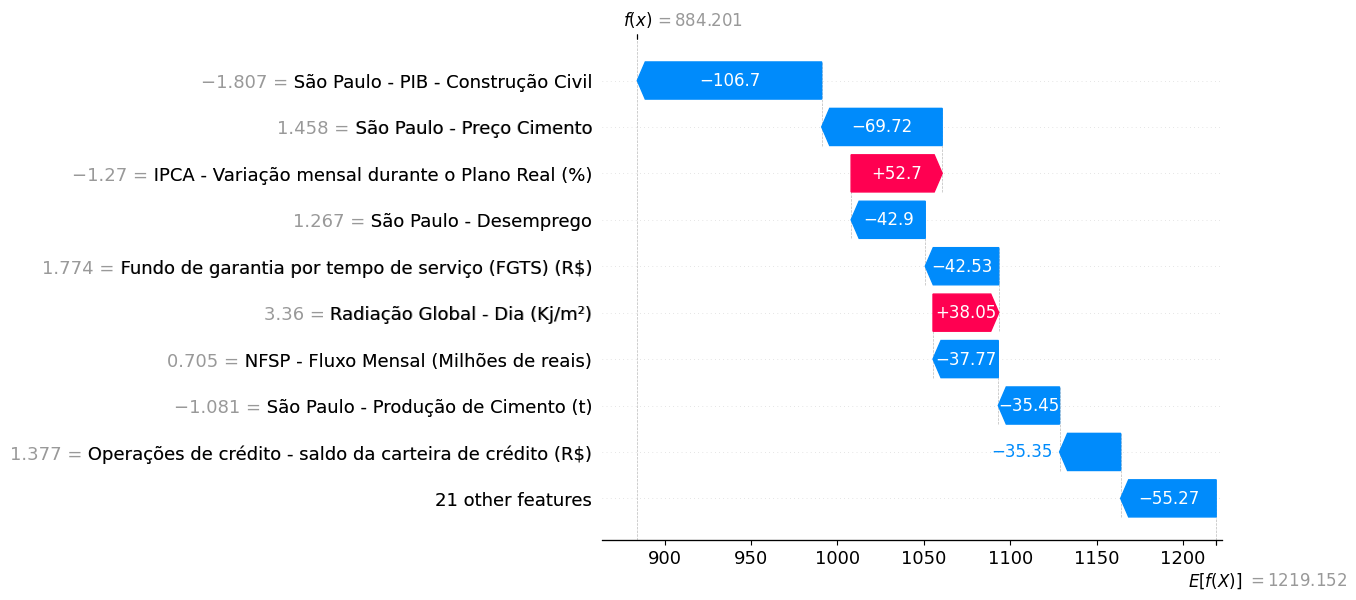

None

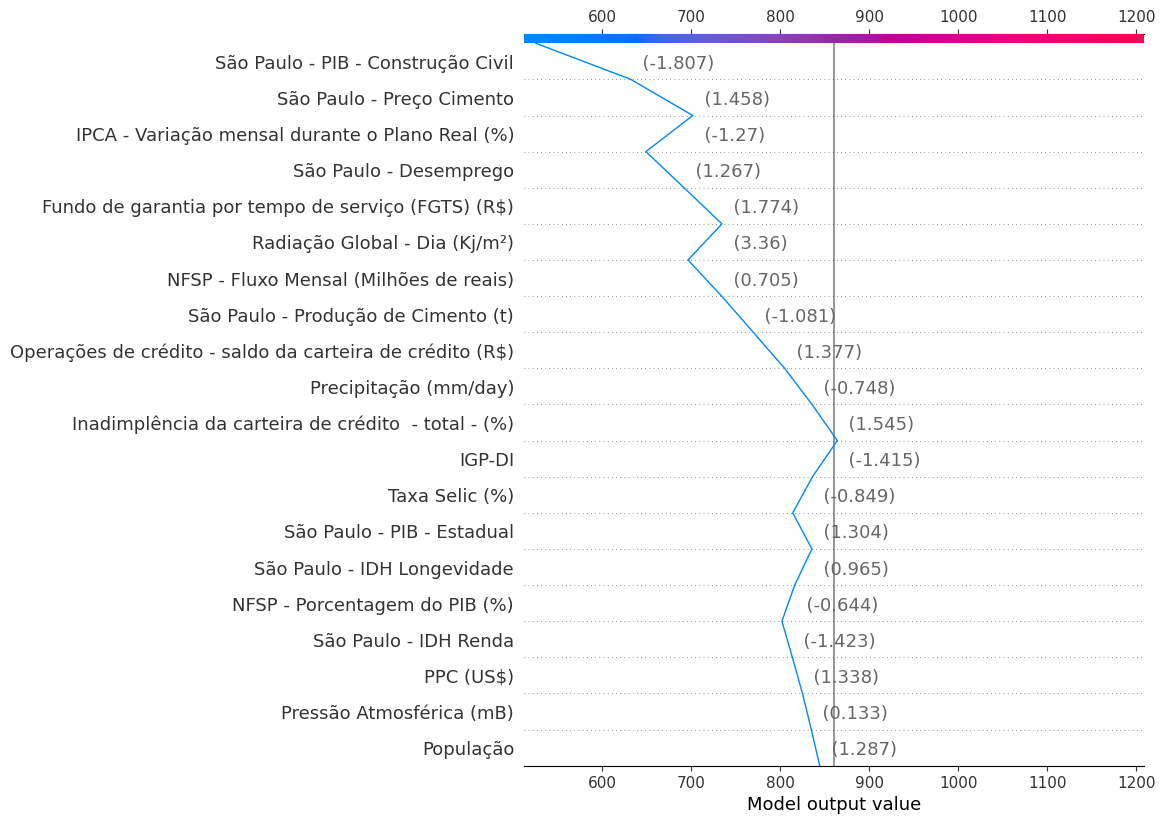

None

['Month-1', 884.2014, 860.232, 23.969421]

1/1 [==============================] - 0s 40ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

66/66 [==============================] - 0s 705us/step


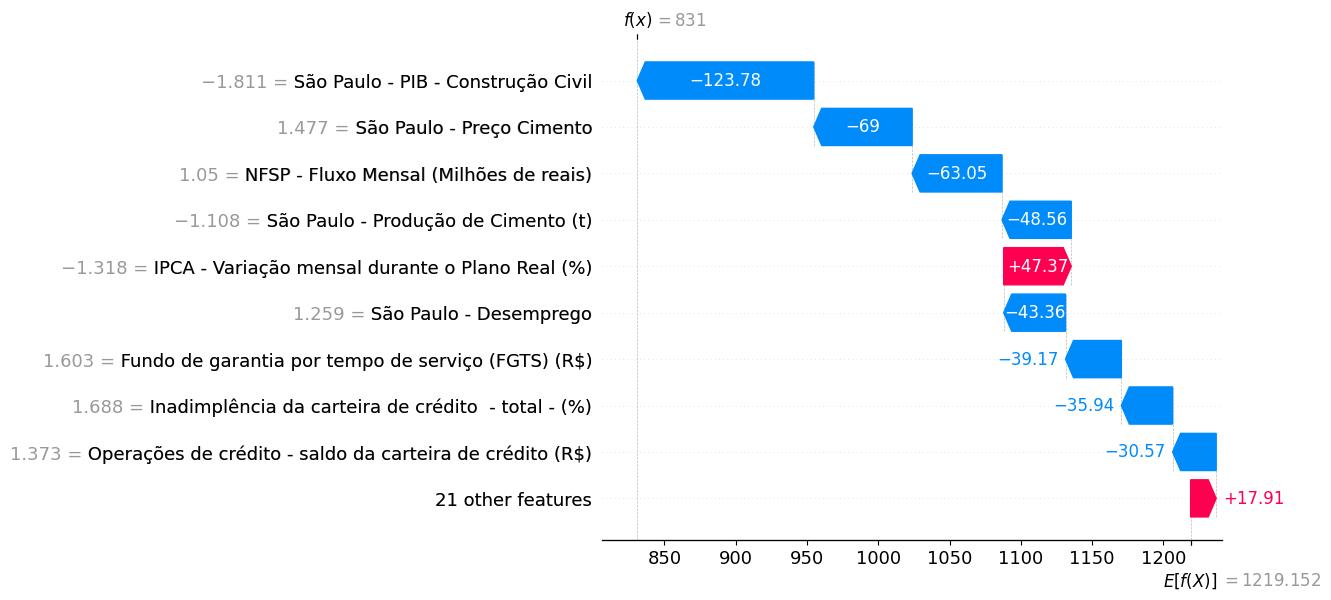

None

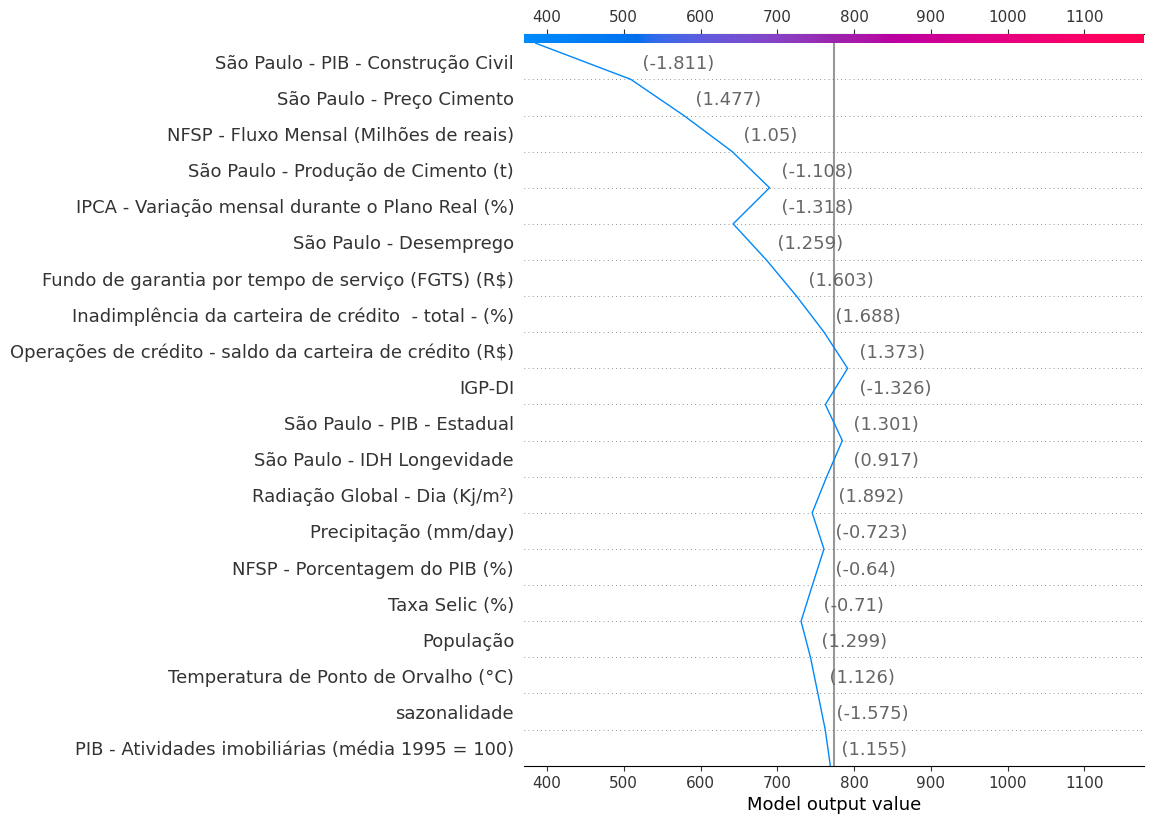

None

['Month-2', 830.9998, 773.607, 57.392822]

1/1 [==============================] - 0s 34ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

66/66 [==============================] - 0s 711us/step


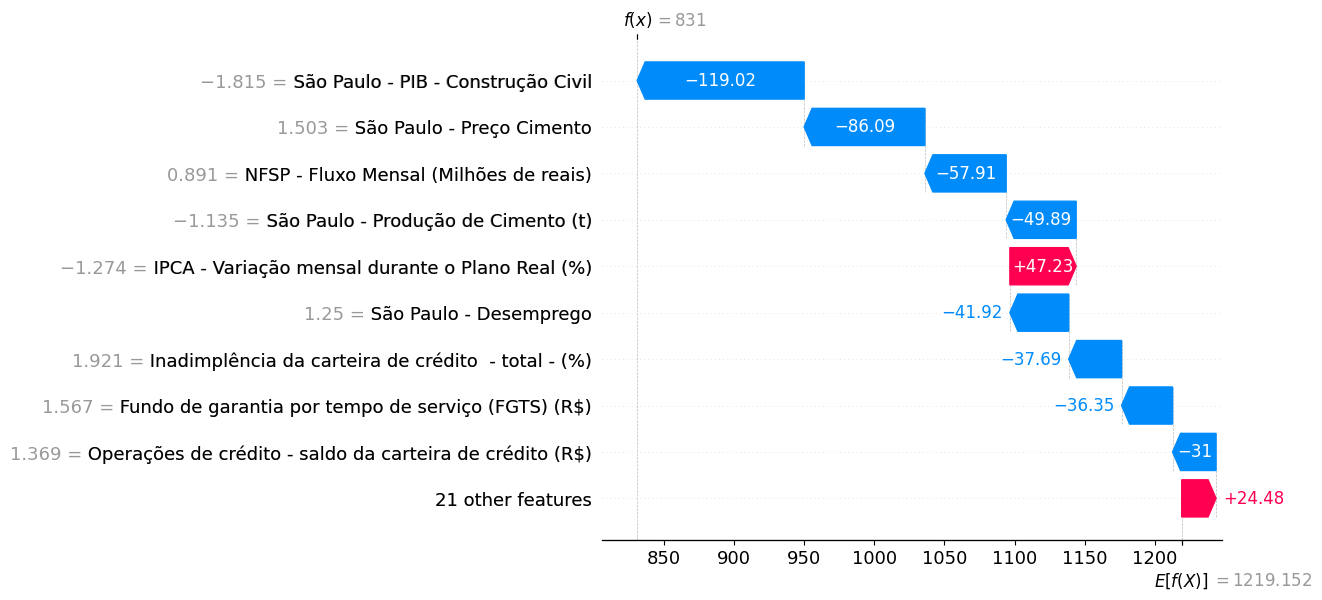

None

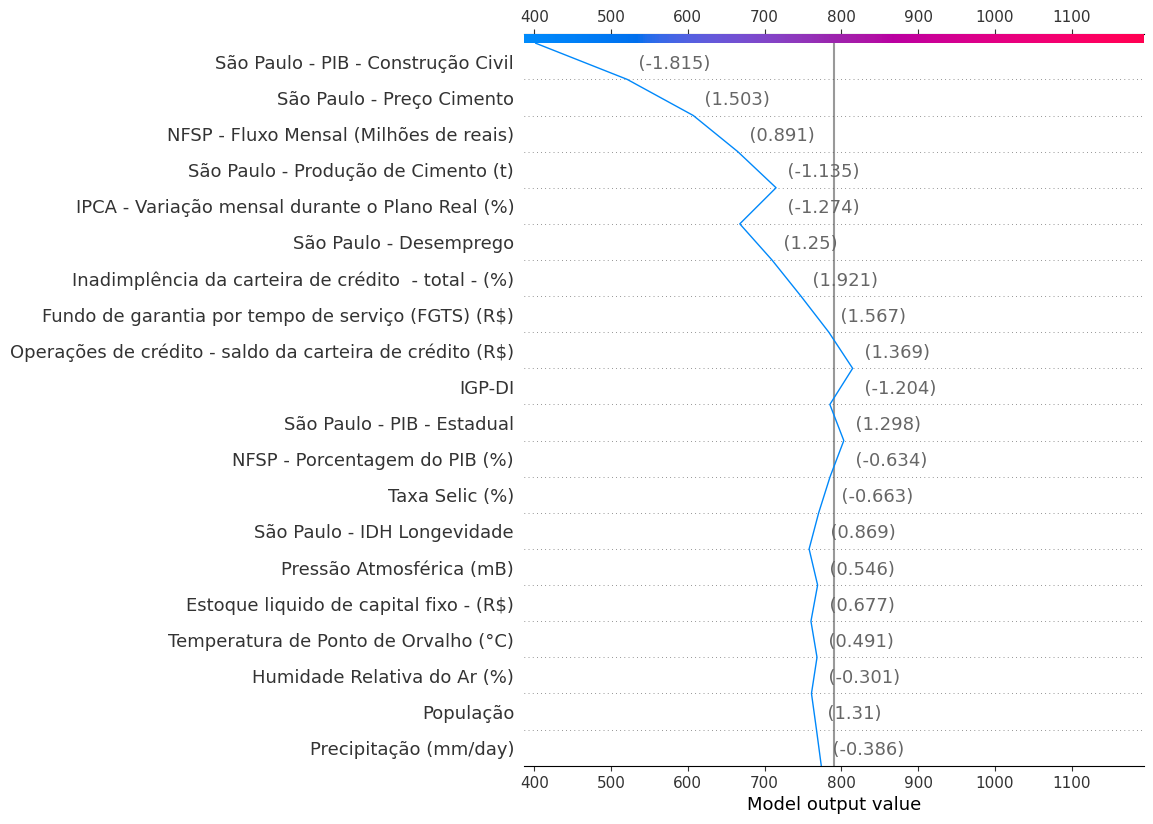

None

['Month-3', 830.9998, 790.146, 40.85382]

1/1 [==============================] - 0s 36ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

66/66 [==============================] - 0s 690us/step


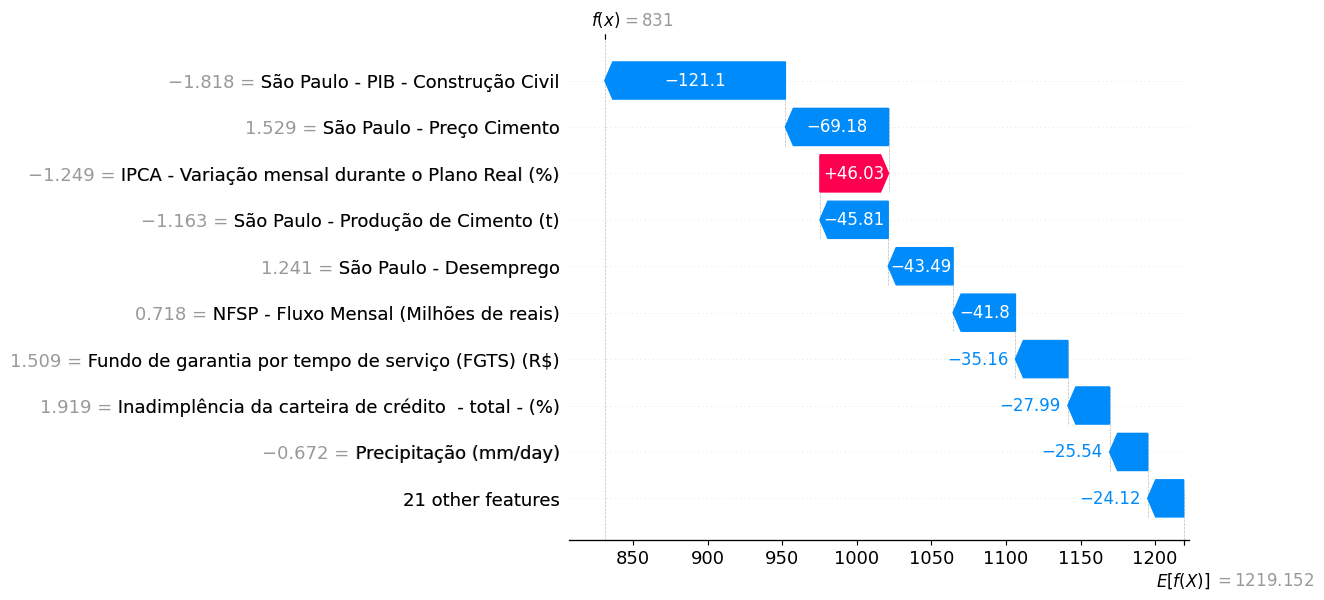

None

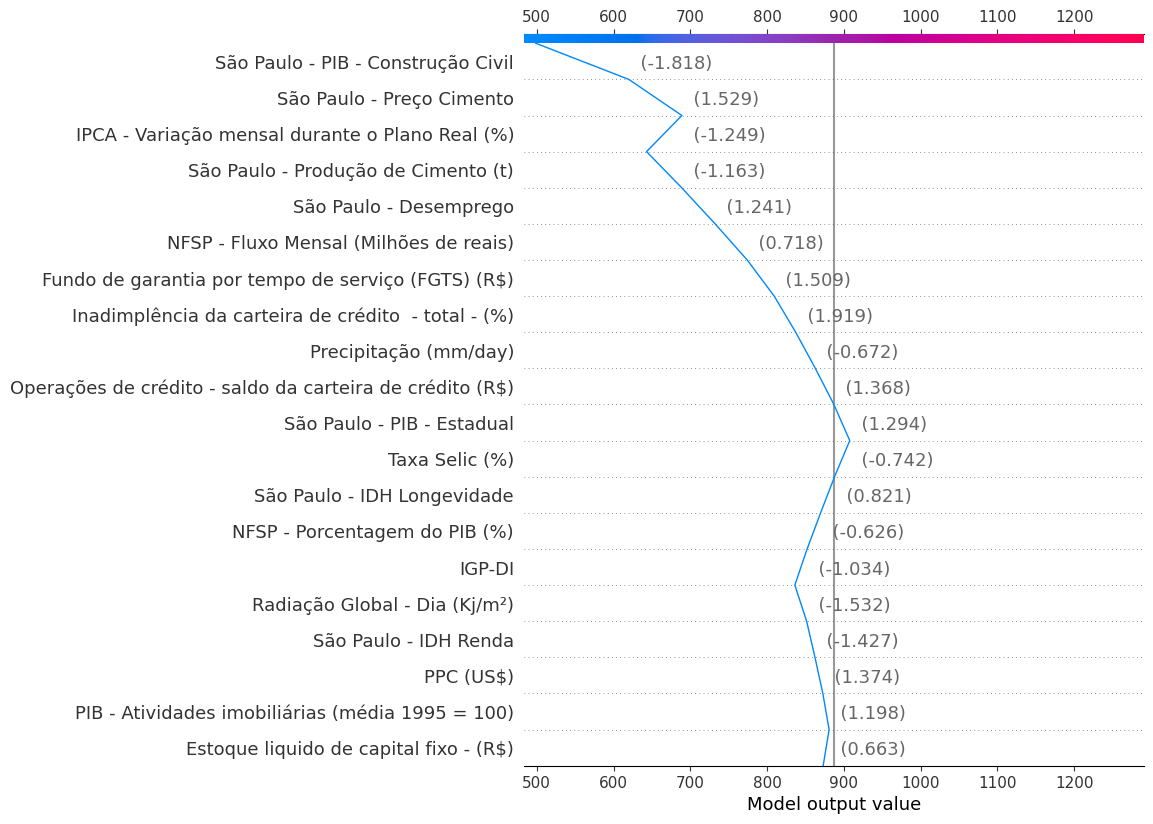

None

['Month-4', 830.9998, 886.929, 55.9292]

1/1 [==============================] - 0s 35ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

66/66 [==============================] - 0s 691us/step


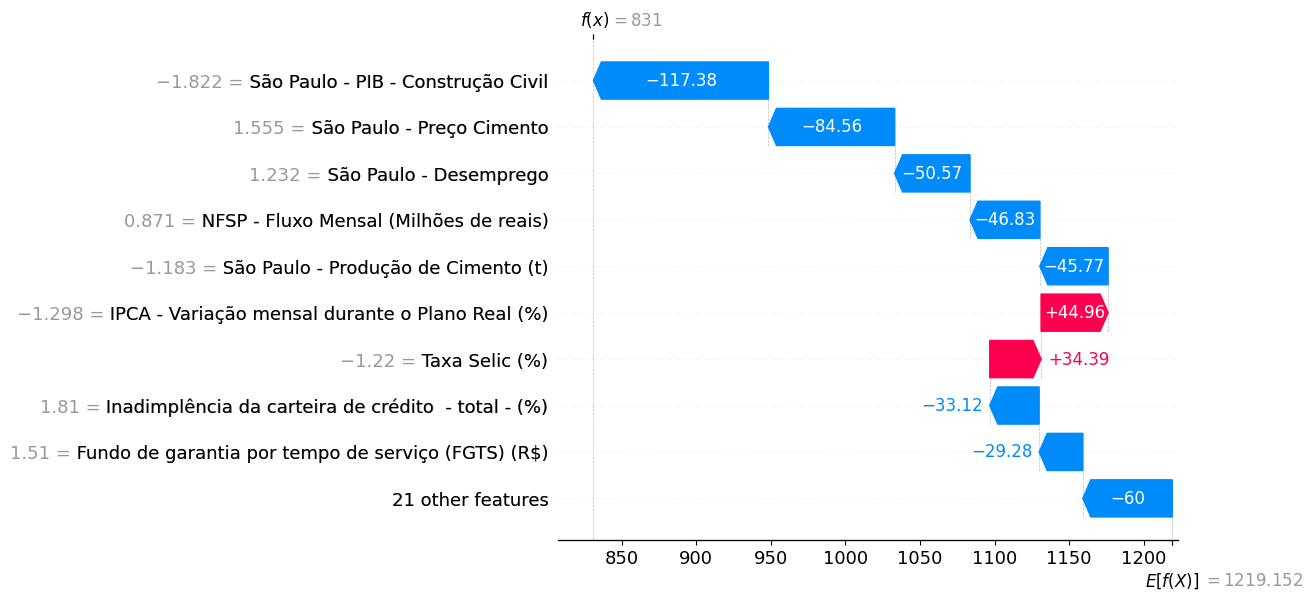

None

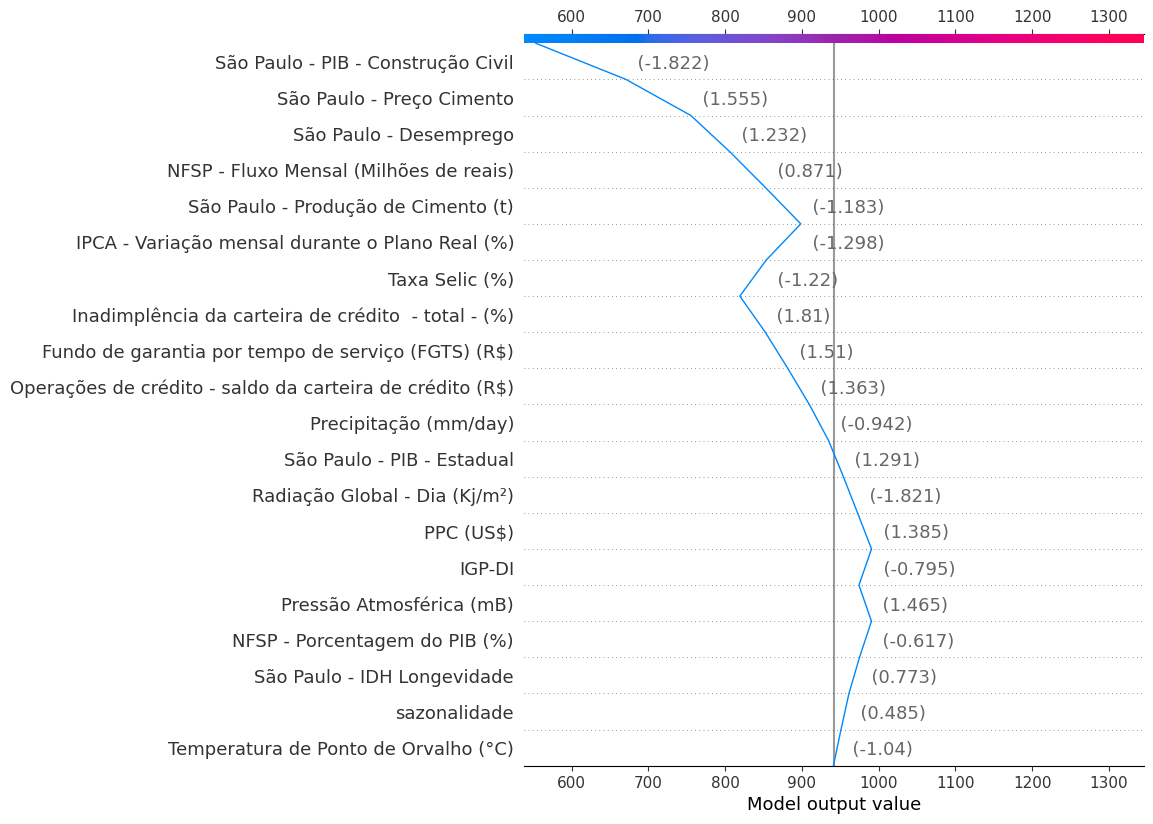

None

['Month-5', 830.9998, 941.6, 110.60016]

1/1 [==============================] - 0s 35ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

66/66 [==============================] - 0s 750us/step


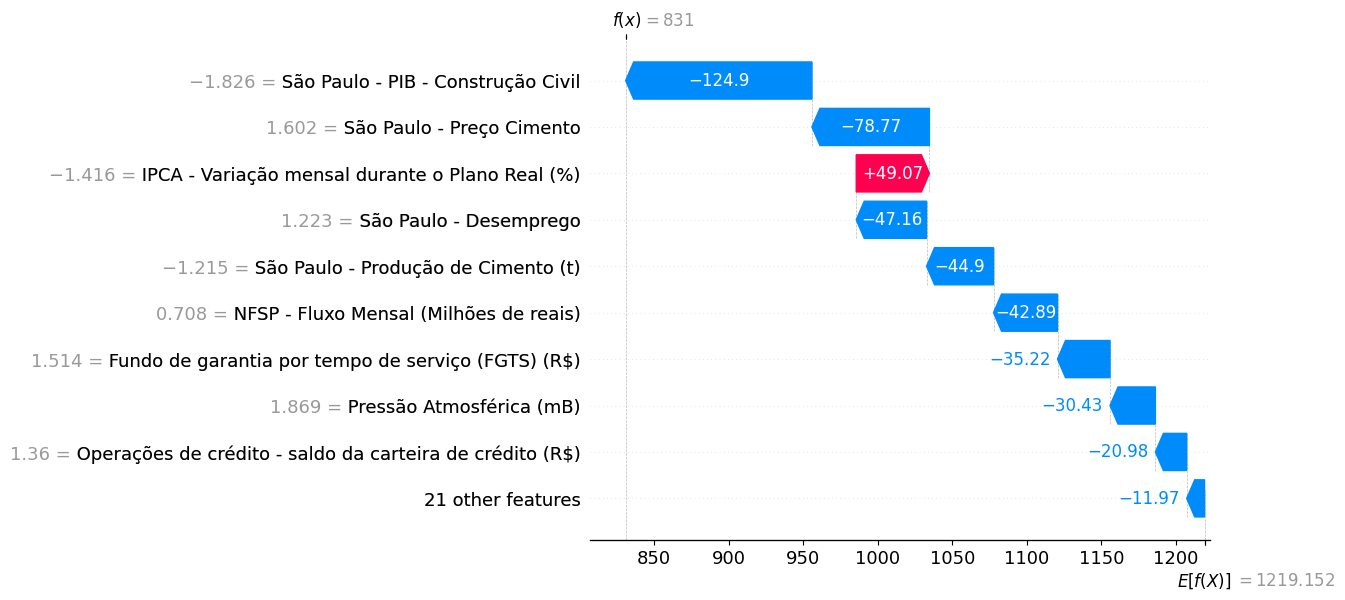

None

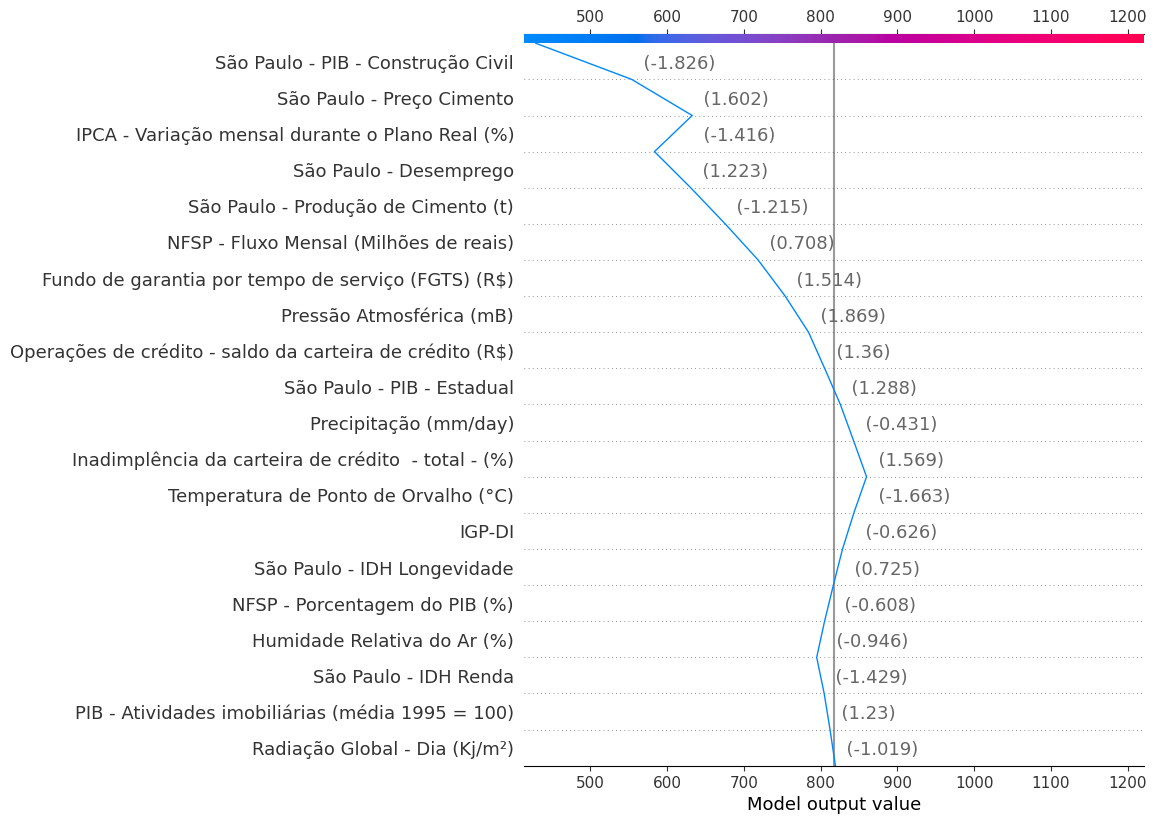

None

['Month-6', 830.9998, 817.301, 13.6987915]

1/1 [==============================] - 0s 38ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

66/66 [==============================] - 0s 737us/step


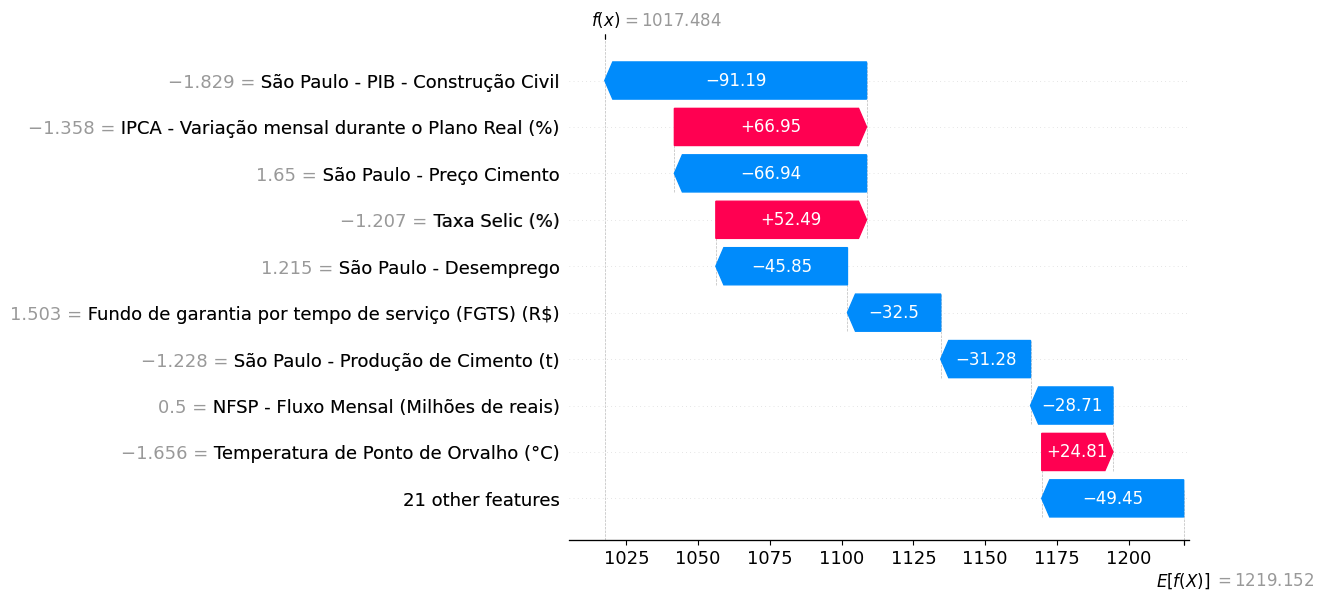

None

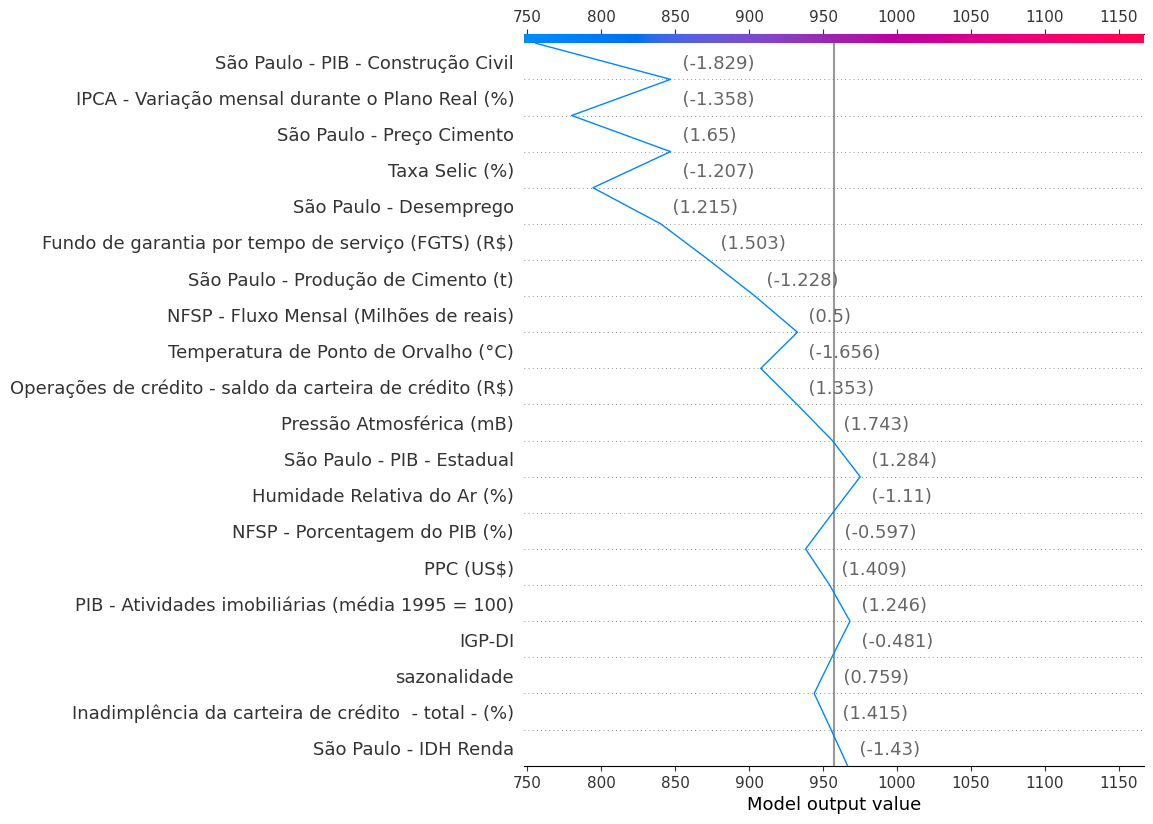

None

['Month-7', 1017.4844, 957.289, 60.195374]

1/1 [==============================] - 0s 36ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

66/66 [==============================] - 0s 713us/step


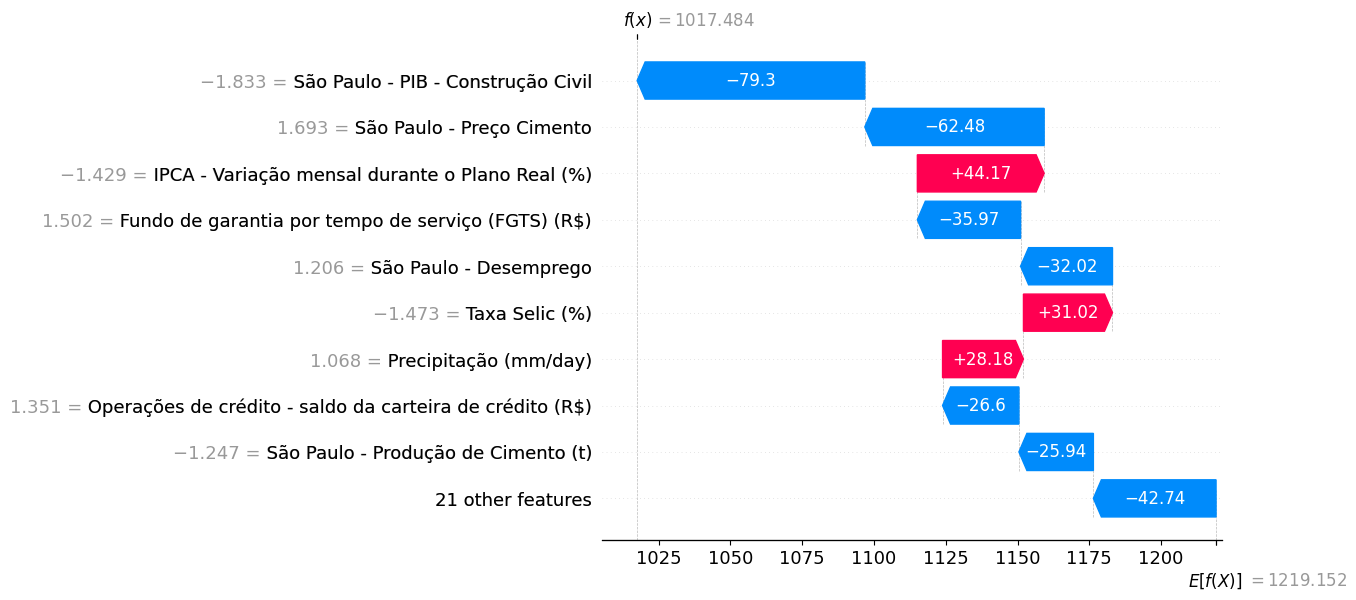

None

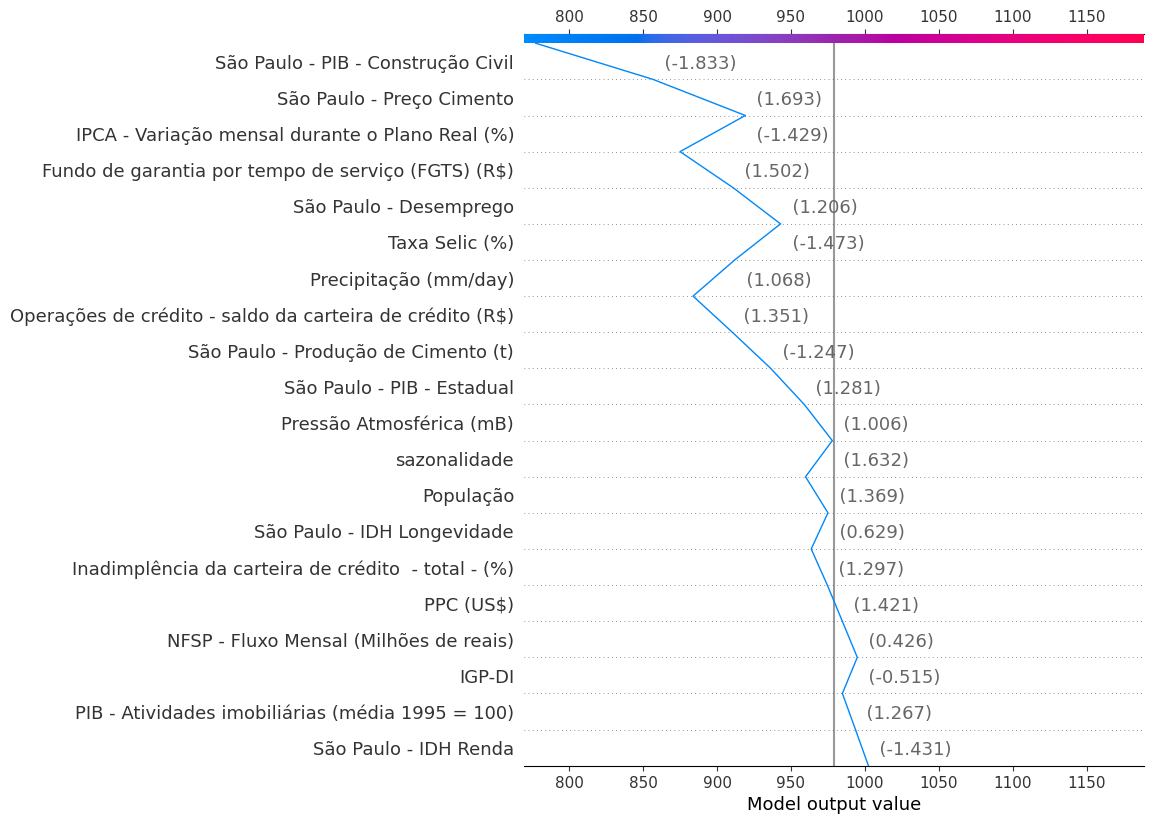

None

['Month-8', 1017.4844, 978.99, 38.494385]

1/1 [==============================] - 0s 42ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

66/66 [==============================] - 0s 718us/step


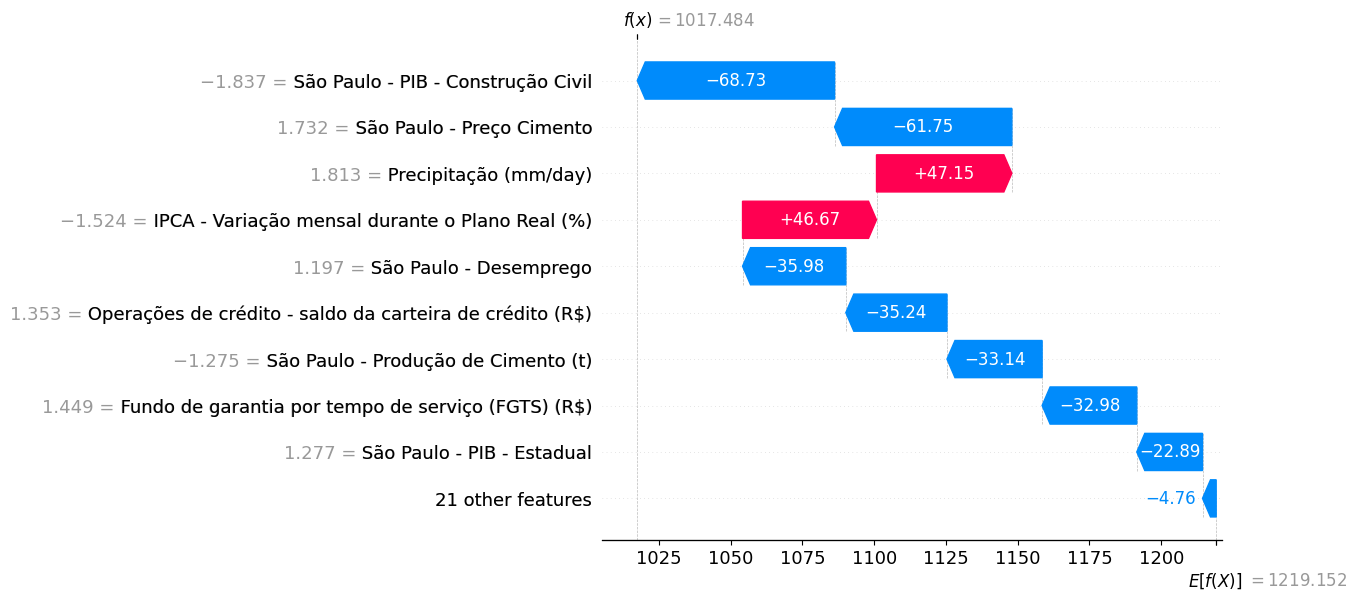

None

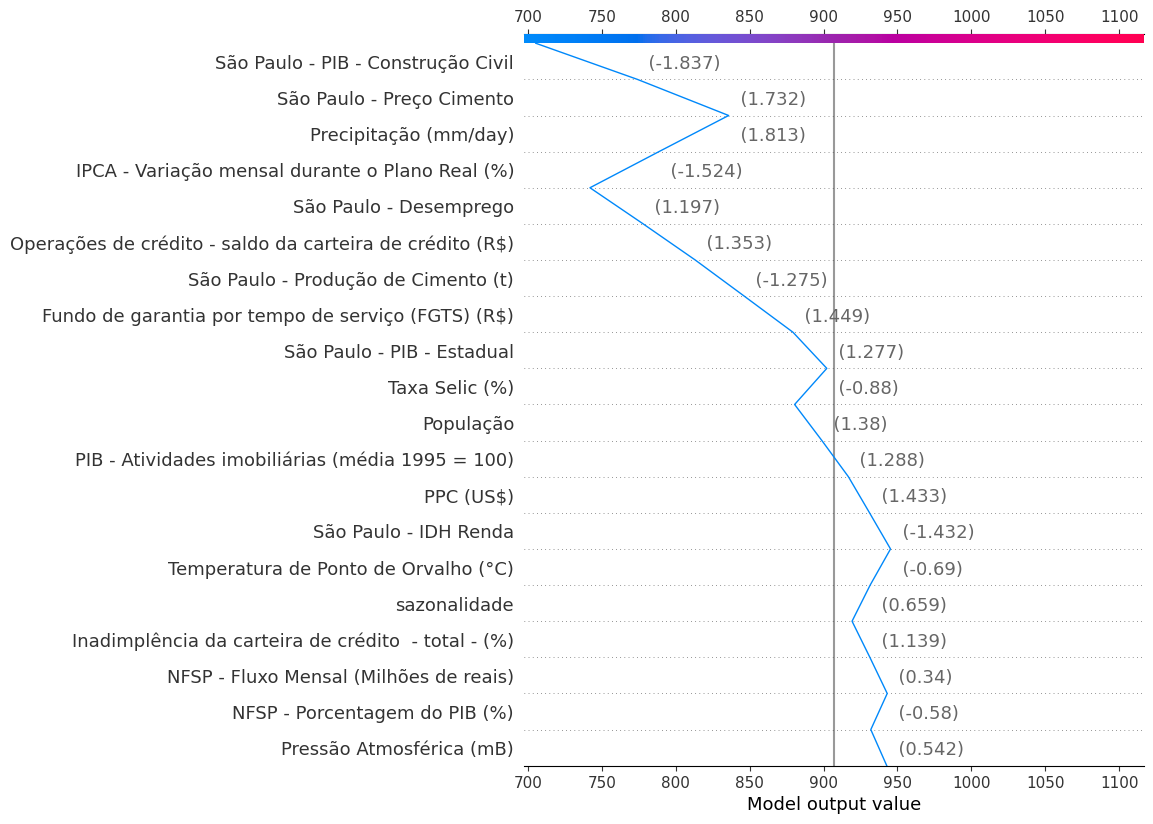

None

['Month-9', 1017.4844, 906.956, 110.52838]

1/1 [==============================] - 0s 37ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

66/66 [==============================] - 0s 711us/step


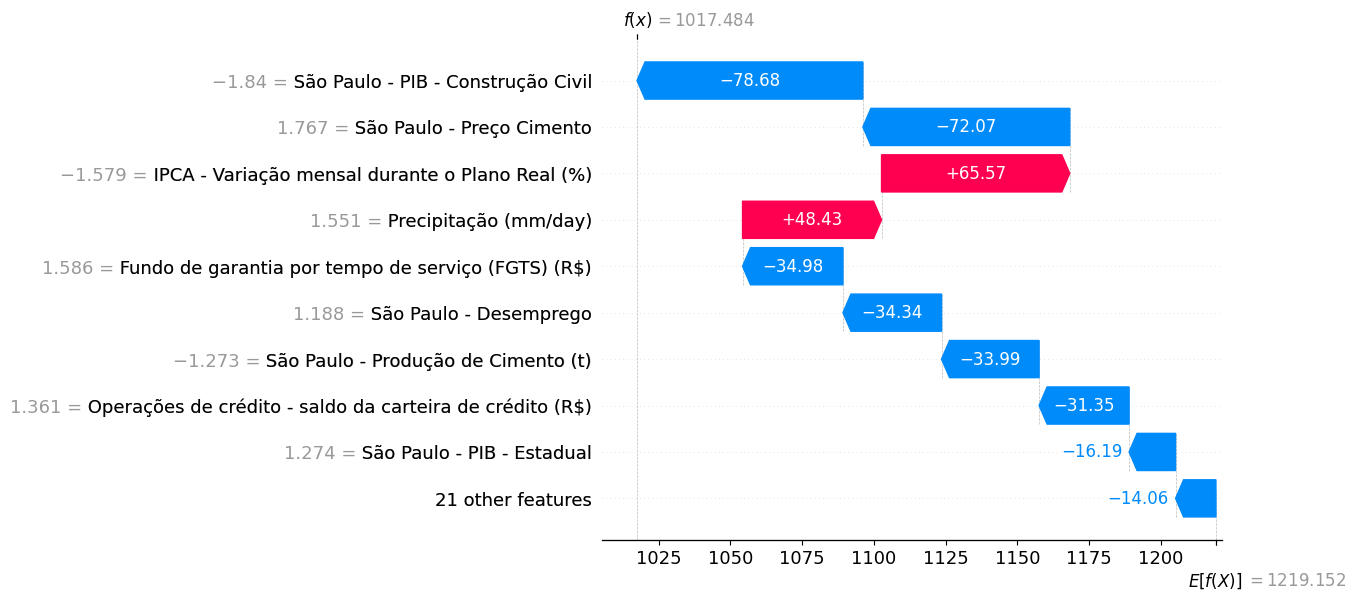

None

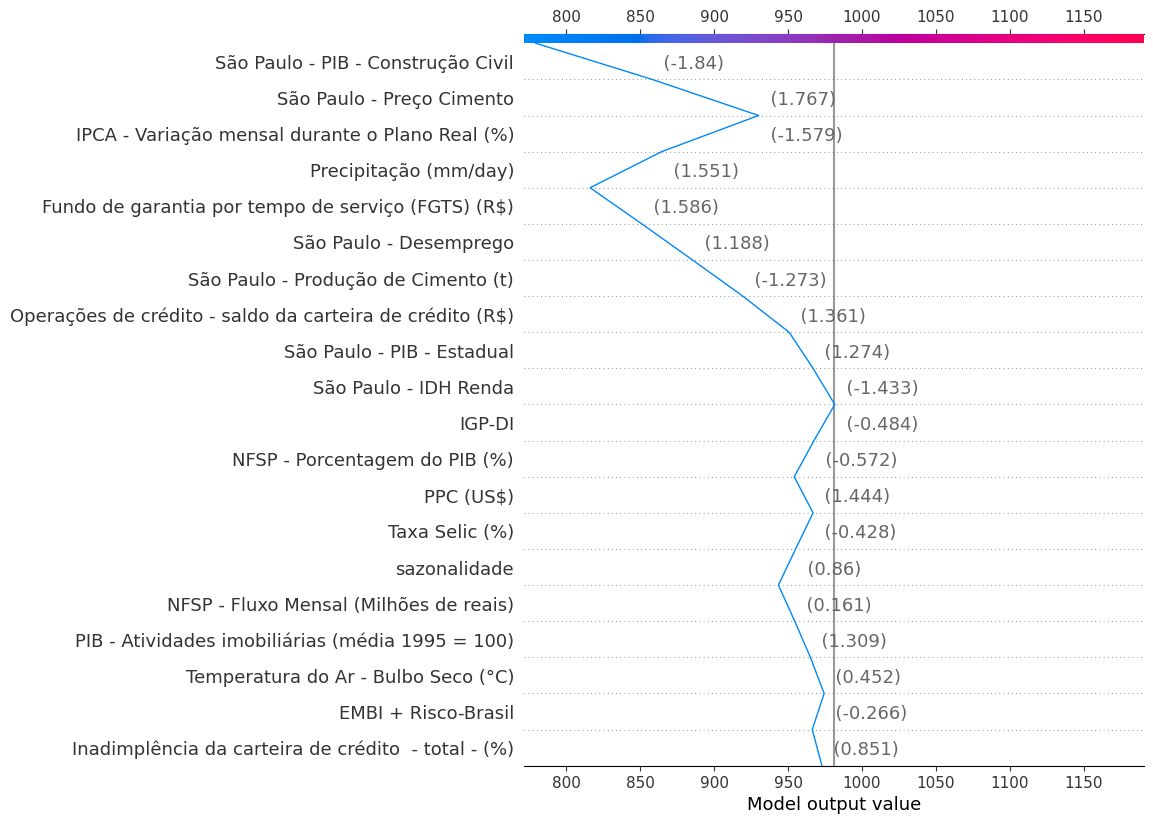

None

['Month-10', 1017.4844, 980.948, 36.536377]

1/1 [==============================] - 0s 35ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

66/66 [==============================] - 0s 728us/step


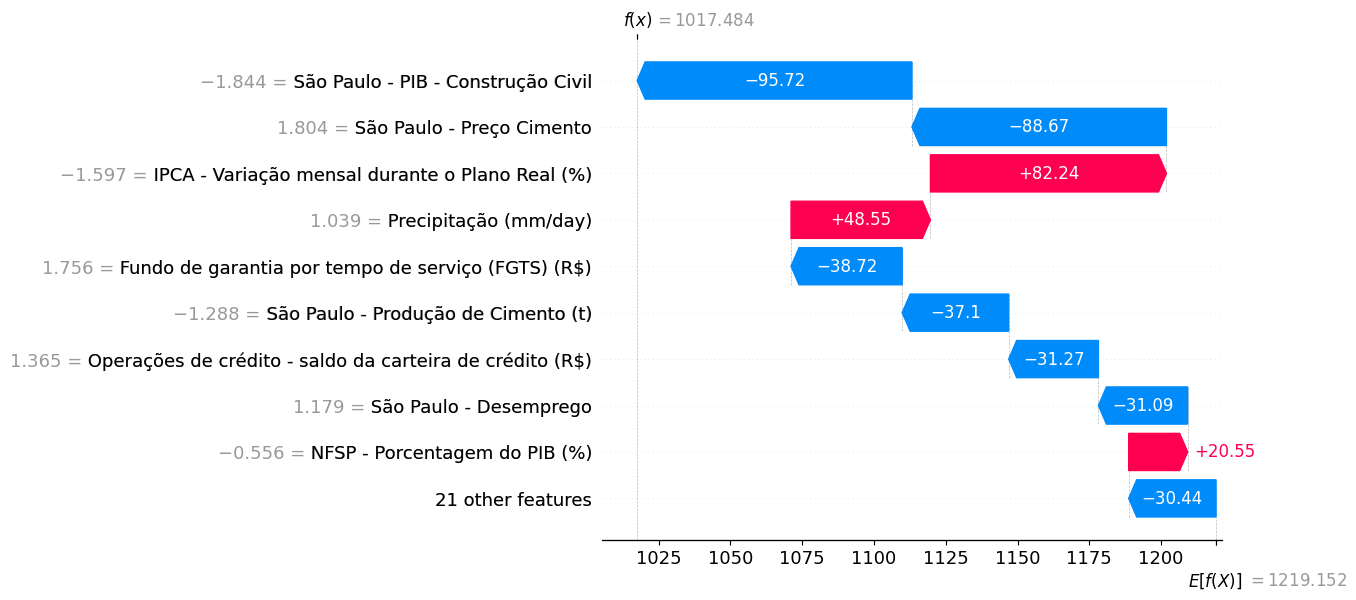

None

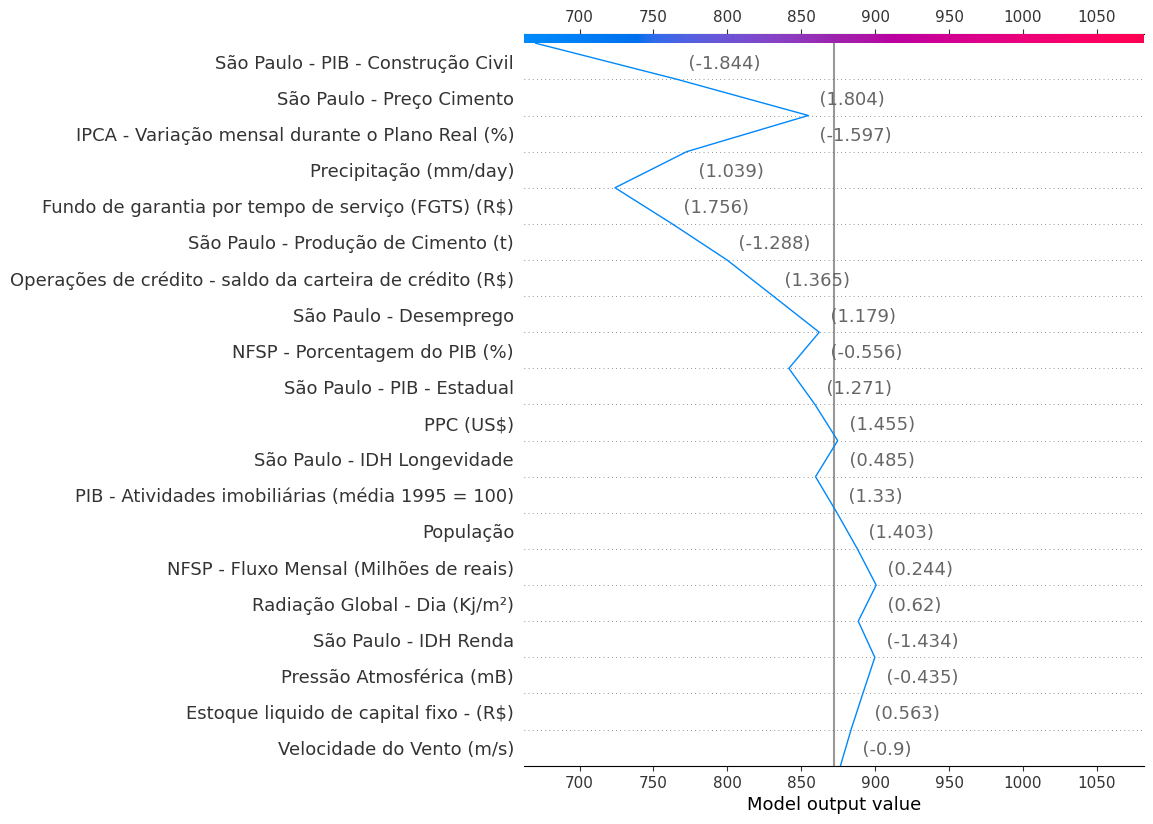

None

['Month-11', 1017.4844, 872.046, 145.43835]

1/1 [==============================] - 0s 35ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

66/66 [==============================] - 0s 673us/step


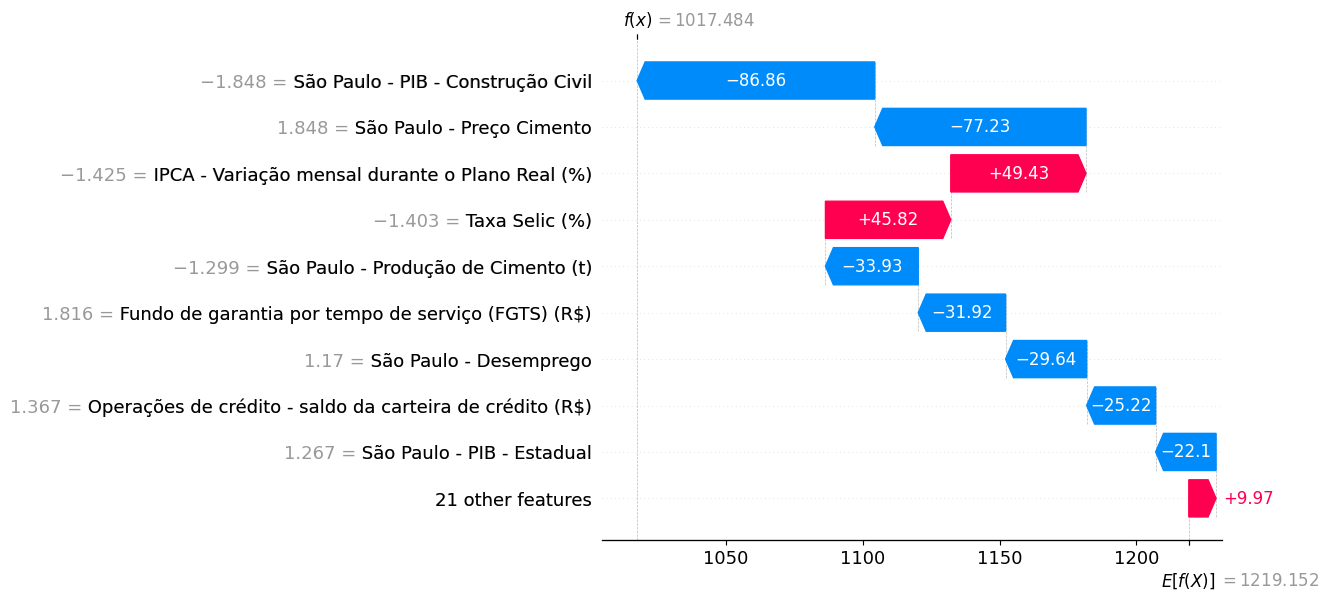

None

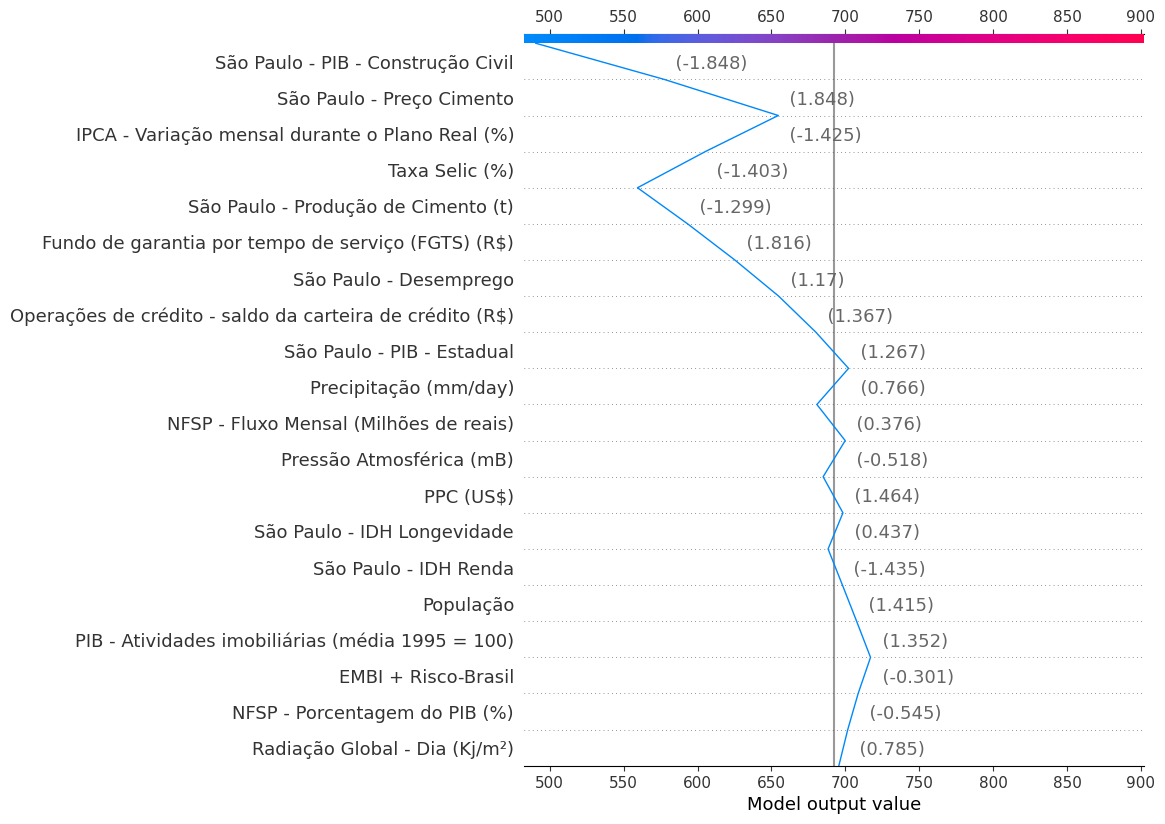

None

['Month-12', 1017.4844, 692.232, 325.25238]

0           1           2           3           4   \
Month          Month-1     Month-2     Month-3     Month-4     Month-5   
Prediction  884.201416  830.999817  830.999817  830.999817  830.999817   
Target         860.232     773.607     790.146     886.929       941.6   
Error        23.969421   57.392822   40.853821   55.929199  110.600159   

                    5            6            7            8            9   \
Month          Month-6      Month-7      Month-8      Month-9     Month-10   
Prediction  830.999817  1017.484375  1017.484375  1017.484375  1017.484375   
Target         817.301      957.289       978.99      906.956      980.948   
Error        13.698792    60.195374    38.494385   110.528381    36.536377   

                     10           11  
Month          Month-11     Month-12  
Prediction  1017.484375  1017.484375  
Target          872.046      692.232  
Error        145.438354    325.25238

In [39]:
df_results, mae, mape = mae_mape_calculator(trained_model, 
                                            train_input,
                                            test_input, 
                                            test_target, 
                                            start_index)
pd.set_option('display.max_columns', None)
df_results.T

In [37]:
display(mae)
display(mape)

84.907455

0.10408255